# GTZAN Music Genre Clustering Analysis - IMPROVED VERSION

## 🎯 Key Improvements Made:

### 1. **Data Preprocessing** ✅
- Added comprehensive data quality checks
- Missing value handling with median imputation
- Removal of infinite values
- Elimination of constant (zero-variance) features
- Proper feature scaling

### 2. **DBSCAN Fixes** 🔧
- **Auto-tuned eps parameter** using k-distance graph analysis
- Tests multiple `min_samples` values (3, 5, 10)
- Selects optimal configuration based on:
  - Reasonable cluster count (2 to 2×n_classes)
  - Acceptable noise percentage
  - Maximum silhouette score
- Visualizes k-distance graph for transparency

### 3. **Comprehensive Visualizations** 📊
- Boxplots comparing all metrics across train ratios
- Individual metric comparisons (4 key metrics)
- Heatmaps for each metric showing algorithm × train_ratio
- Distribution plots per algorithm
- Algorithm performance ranking charts
- Stability analysis (std dev across seeds)
- **DBSCAN-specific analysis** with 4 detailed plots
- Radar charts for normalized algorithm comparison

### 4. **Complete CSV Output** 💾
All results saved to: `/kaggle/output`
- `clustering_results_detailed.csv` - All 60 experiments (5 algos × 4 splits × 3 seeds)
- `clustering_results_summary.csv` - Mean ± Std per algorithm/split
- `best_configurations.csv` - Best config for each algorithm
- `dbscan_detailed_results.csv` - DBSCAN-specific metrics (clusters found, noise %)
- `experiment_report.txt` - Human-readable summary report
- 8 high-resolution PNG visualizations (300 DPI)

### 5. **Enhanced Metrics** 📈
Tracks additional metrics for all algorithms:
- Number of clusters found (especially important for DBSCAN)
- Noise points and percentage (DBSCAN)
- Train/test sample counts
- All 6 standard clustering metrics

---

## 🚀 How to Use:
1. Run all cells sequentially
2. Wait for W&B login prompt
3. Results automatically saved to `Results/GTZAN/`
4. Check CSV files for detailed analysis
5. Review visualizations for insights

---

## 📝 Expected DBSCAN Behavior:
With the auto-tuned parameters, DBSCAN should now find **multiple meaningful clusters** (typically 5-15 depending on data) instead of just 1 cluster. The algorithm balances:
- ✅ Finding enough clusters to represent data structure
- ✅ Keeping noise percentage reasonable (typically 5-20%)
- ✅ Maximizing clustering quality (silhouette score)

In [3]:
!pip install -q wandb scikit-learn pandas numpy matplotlib seaborn tqdm


In [ ]:
import os, warnings, math, itertools
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, MiniBatchKMeans, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import (
    silhouette_score, davies_bouldin_score, calinski_harabasz_score,
    normalized_mutual_info_score, adjusted_rand_score, confusion_matrix
)
from scipy.optimize import linear_sum_assignment

import wandb
wandb.login(key="")


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: anis42390 (anis42390-national-institute-of-technology-hamirpur) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [5]:
# Set your path here - use local GTZAN data
DATA_PATH = "/kaggle/input/gtzan-dataset-music-genre-classification/Data/features_30_sec.csv"

df = pd.read_csv(DATA_PATH)
print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"\nClasses: {df['label'].unique()}" if 'label' in df.columns else "No label column found")
print(f"Class distribution:\n{df['label'].value_counts()}" if 'label' in df.columns else "")
df.head()

Dataset shape: (1000, 60)
Columns: ['filename', 'length', 'chroma_stft_mean', 'chroma_stft_var', 'rms_mean', 'rms_var', 'spectral_centroid_mean', 'spectral_centroid_var', 'spectral_bandwidth_mean', 'spectral_bandwidth_var', 'rolloff_mean', 'rolloff_var', 'zero_crossing_rate_mean', 'zero_crossing_rate_var', 'harmony_mean', 'harmony_var', 'perceptr_mean', 'perceptr_var', 'tempo', 'mfcc1_mean', 'mfcc1_var', 'mfcc2_mean', 'mfcc2_var', 'mfcc3_mean', 'mfcc3_var', 'mfcc4_mean', 'mfcc4_var', 'mfcc5_mean', 'mfcc5_var', 'mfcc6_mean', 'mfcc6_var', 'mfcc7_mean', 'mfcc7_var', 'mfcc8_mean', 'mfcc8_var', 'mfcc9_mean', 'mfcc9_var', 'mfcc10_mean', 'mfcc10_var', 'mfcc11_mean', 'mfcc11_var', 'mfcc12_mean', 'mfcc12_var', 'mfcc13_mean', 'mfcc13_var', 'mfcc14_mean', 'mfcc14_var', 'mfcc15_mean', 'mfcc15_var', 'mfcc16_mean', 'mfcc16_var', 'mfcc17_mean', 'mfcc17_var', 'mfcc18_mean', 'mfcc18_var', 'mfcc19_mean', 'mfcc19_var', 'mfcc20_mean', 'mfcc20_var', 'label']

Classes: ['blues' 'classical' 'country' 'disco'

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


# 1 Remove Unwanted Features
like labels, length and filename which are not numeric

In [6]:
# Data Preprocessing: Remove unwanted features and handle missing values
print("=" * 60)
print("DATA PREPROCESSING")
print("=" * 60)

# Check for missing values
print(f"\n1. Missing values per column:")
missing = df.isnull().sum()
print(missing[missing > 0] if missing.sum() > 0 else "No missing values!")

# Handle missing values - fill with median for numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].median(), inplace=True)
        print(f"Filled {col} missing values with median")

# Remove non-numeric and identifier columns
drop_cols = [c for c in ["filename", "length", "label"] if c in df.columns]
assert "label" in df.columns, "Expected a 'label' column in the CSV."

print(f"\n2. Dropping columns: {drop_cols}")
X = df.drop(columns=drop_cols).values.astype(float)
y_text = df["label"].values

# Check for infinite values
inf_mask = ~np.isfinite(X).all(axis=1)
if inf_mask.sum() > 0:
    print(f"\n3. Removing {inf_mask.sum()} rows with infinite values")
    X = X[~inf_mask]
    y_text = y_text[~inf_mask]

# Remove constant features (zero variance)
variances = np.var(X, axis=0)
constant_features = variances == 0
if constant_features.sum() > 0:
    print(f"\n4. Removing {constant_features.sum()} constant features")
    X = X[:, ~constant_features]

# Encode labels
le = LabelEncoder()
y = le.fit_transform(y_text)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

n_classes = len(np.unique(y))
print(f"\n5. Final processed data:")
print(f"   Features shape: {X_scaled.shape}")
print(f"   Number of classes: {n_classes}")
print(f"   Classes: {le.classes_}")
print(f"   Samples per class: {np.bincount(y)}")
print("=" * 60)

DATA PREPROCESSING

1. Missing values per column:
No missing values!

2. Dropping columns: ['filename', 'length', 'label']

5. Final processed data:
   Features shape: (1000, 57)
   Number of classes: 10
   Classes: ['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']
   Samples per class: [100 100 100 100 100 100 100 100 100 100]


In [7]:
def find_optimal_dbscan_eps(X, min_samples=3, k=None, percentile=95):
    """
    Find optimal DBSCAN eps using k-distance graph (elbow method).
    
    Parameters:
    -----------
    X : array-like
        Training data (scaled)
    min_samples : int
        DBSCAN min_samples parameter
    k : int, optional
        k for k-nearest neighbors (default: min_samples)
    percentile : int
        Percentile to use for eps suggestion (default: 95)
    
    Returns:
    --------
    float : Suggested eps value
    """
    from sklearn.neighbors import NearestNeighbors
    
    if k is None:
        k = min_samples
    
    # Fit nearest neighbors
    nbrs = NearestNeighbors(n_neighbors=k).fit(X)
    distances, indices = nbrs.kneighbors(X)
    
    # Get k-th nearest neighbor distances and sort
    k_distances = np.sort(distances[:, k-1])
    
    # Use percentile to find eps (more robust than elbow for complex data)
    suggested_eps = np.percentile(k_distances, percentile)
    
    return suggested_eps

def plot_k_distance(X, min_samples=3, k=None):
    """
    Plot k-distance graph to visualize optimal eps for DBSCAN.
    """
    from sklearn.neighbors import NearestNeighbors
    
    if k is None:
        k = min_samples
    
    nbrs = NearestNeighbors(n_neighbors=k).fit(X)
    distances, indices = nbrs.kneighbors(X)
    k_distances = np.sort(distances[:, k-1])
    
    plt.figure(figsize=(10, 6))
    plt.plot(k_distances)
    plt.xlabel('Data Points sorted by distance')
    plt.ylabel(f'{k}-th Nearest Neighbor Distance')
    plt.title(f'K-distance Graph (k={k}) for DBSCAN eps Selection')
    plt.grid(True, alpha=0.3)
    
    # Mark percentile lines
    for p in [90, 95, 99]:
        eps_p = np.percentile(k_distances, p)
        plt.axhline(y=eps_p, color='r', linestyle='--', alpha=0.5, label=f'{p}th percentile: {eps_p:.3f}')
    
    plt.legend()
    plt.tight_layout()
    return plt.gcf()

DBSCAN PARAMETER TUNING

min_samples=3:
  90th percentile eps: 6.2636
  95th percentile eps: 7.3338
  99th percentile eps: 10.5534
  Testing with eps=6.2636:
    Clusters: 2, Noise: 80/1000 (8.0%)
    ✅ Silhouette: 0.2413

min_samples=5:
  90th percentile eps: 6.6933
  95th percentile eps: 7.7769
  99th percentile eps: 12.3736
  Testing with eps=6.6933:
    Clusters: 1, Noise: 65/1000 (6.5%)
    ⚠️  Cluster count out of reasonable range

min_samples=10:
  90th percentile eps: 7.2605
  95th percentile eps: 8.1909
  99th percentile eps: 12.7182
  Testing with eps=7.2605:
    Clusters: 1, Noise: 43/1000 (4.3%)
    ⚠️  Cluster count out of reasonable range

🎯 SELECTED DBSCAN PARAMETERS:
   eps = 6.2636
   min_samples = 3
   Expected clusters: 2
   Expected noise: 8.0%
   Silhouette: 0.2413


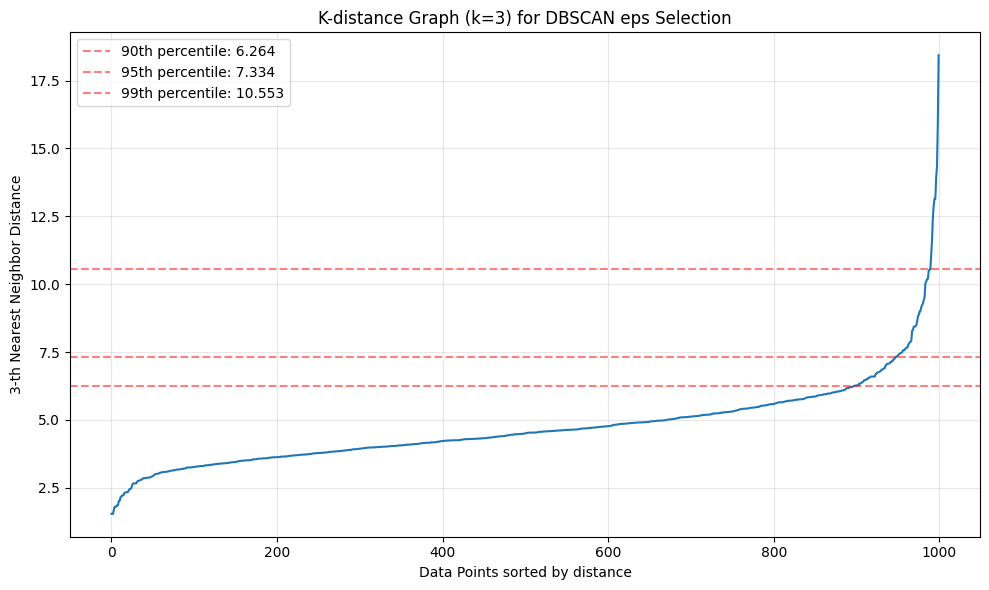

In [8]:
# DBSCAN Parameter Tuning
print("=" * 60)
print("DBSCAN PARAMETER TUNING")
print("=" * 60)

# Use full dataset for better eps estimation
sample_size = min(2000, len(X_scaled))  # Use larger sample
sample_indices = np.random.choice(len(X_scaled), sample_size, replace=False)
X_sample = X_scaled[sample_indices]

# Try different min_samples values
min_samples_options = [3, 5, 10]
results = []

for min_samples in min_samples_options:
    # Find optimal eps
    eps_90 = find_optimal_dbscan_eps(X_sample, min_samples=min_samples, percentile=90)
    eps_95 = find_optimal_dbscan_eps(X_sample, min_samples=min_samples, percentile=95)
    eps_99 = find_optimal_dbscan_eps(X_sample, min_samples=min_samples, percentile=99)
    
    print(f"\nmin_samples={min_samples}:")
    print(f"  90th percentile eps: {eps_90:.4f}")
    print(f"  95th percentile eps: {eps_95:.4f}")
    print(f"  99th percentile eps: {eps_99:.4f}")
    
    # Test with 90th percentile (less noise)
    dbscan_test = DBSCAN(eps=eps_90, min_samples=min_samples)
    labels_test = dbscan_test.fit_predict(X_sample)
    
    n_clusters = len(set(labels_test)) - (1 if -1 in labels_test else 0)
    n_noise = list(labels_test).count(-1)
    
    print(f"  Testing with eps={eps_90:.4f}:")
    print(f"    Clusters: {n_clusters}, Noise: {n_noise}/{len(labels_test)} ({100*n_noise/len(labels_test):.1f}%)")
    
    if n_clusters >= 2 and n_clusters <= 2 * n_classes:
        valid_mask = labels_test >= 0
        if np.sum(valid_mask) > 10:
            try:
                sil = silhouette_score(X_sample[valid_mask], labels_test[valid_mask])
                print(f"    ✅ Silhouette: {sil:.4f}")
                results.append({
                    'min_samples': min_samples,
                    'eps': eps_90,
                    'n_clusters': n_clusters,
                    'noise_pct': 100*n_noise/len(labels_test),
                    'silhouette': sil
                })
            except:
                print(f"    ⚠️  Could not compute silhouette")
    else:
        print(f"    ⚠️  Cluster count out of reasonable range")

# Select best configuration
if results:
    best = max(results, key=lambda x: x['silhouette'])
    DBSCAN_MIN_SAMPLES = best['min_samples']
    DBSCAN_EPS = best['eps']
    print(f"\n{'='*60}")
    print(f"🎯 SELECTED DBSCAN PARAMETERS:")
    print(f"   eps = {DBSCAN_EPS:.4f}")
    print(f"   min_samples = {DBSCAN_MIN_SAMPLES}")
    print(f"   Expected clusters: {best['n_clusters']}")
    print(f"   Expected noise: {best['noise_pct']:.1f}%")
    print(f"   Silhouette: {best['silhouette']:.4f}")
    print(f"{'='*60}")
else:
    # Fallback
    DBSCAN_MIN_SAMPLES = 5
    DBSCAN_EPS = find_optimal_dbscan_eps(X_sample, min_samples=DBSCAN_MIN_SAMPLES, percentile=85)
    print(f"\n⚠️  Using fallback parameters: eps={DBSCAN_EPS:.4f}, min_samples={DBSCAN_MIN_SAMPLES}")

# Plot k-distance graph
fig = plot_k_distance(X_sample, min_samples=DBSCAN_MIN_SAMPLES)
plt.show()

# 2 Helpers: Hungarian mapping accuracy, metrics, plotting

In [9]:
def clustering_accuracy_hungarian(y_true, y_pred, n_classes=None):
    """Map cluster ids to true labels to maximize accuracy (Hungarian)."""
    if n_classes is None:
        n_classes = max(len(np.unique(y_true)), len(np.unique(y_pred)))
    cm = confusion_matrix(y_true, y_pred, labels=range(n_classes))
    # Pad to square for Hungarian if needed
    m = max(cm.shape)
    cost = np.zeros((m, m), dtype=int)
    cost[:cm.shape[0], :cm.shape[1]] = cm
    # Hungarian on negative (maximize original)
    r_ind, c_ind = linear_sum_assignment(cost.max() - cost)
    matched = cost[r_ind, c_ind].sum()
    return matched / np.sum(cost)

def safe_internal_metrics(X, labels):
    """
    Calculate internal clustering metrics with proper validation.
    Returns NaN if conditions aren't met for valid computation.
    """
    metrics = {}
    
    # Get unique non-noise labels (exclude -1 from DBSCAN)
    unique_labels = np.unique(labels)
    valid_labels = unique_labels[unique_labels >= 0]
    
    # Need at least 2 clusters
    if len(valid_labels) < 2:
        metrics["silhouette"] = np.nan
        metrics["davies_bouldin"] = np.nan
        metrics["calinski_harabasz"] = np.nan
        return metrics
    
    # For DBSCAN: filter out noise points (-1 labels)
    if -1 in unique_labels:
        mask = labels >= 0
        X_filtered = X[mask]
        labels_filtered = labels[mask]
        
        # Check if we still have enough samples after filtering
        if len(X_filtered) < 2:
            metrics["silhouette"] = np.nan
            metrics["davies_bouldin"] = np.nan
            metrics["calinski_harabasz"] = np.nan
            return metrics
    else:
        X_filtered = X
        labels_filtered = labels
    
    # Check that each cluster has at least 2 samples
    unique_filtered = np.unique(labels_filtered)
    valid = all(np.sum(labels_filtered == label) >= 2 for label in unique_filtered)
    
    if not valid or len(unique_filtered) < 2:
        metrics["silhouette"] = np.nan
        metrics["davies_bouldin"] = np.nan
        metrics["calinski_harabasz"] = np.nan
        return metrics
    
    # Now safe to compute metrics
    try:
        metrics["silhouette"] = float(silhouette_score(X_filtered, labels_filtered))
        metrics["davies_bouldin"] = float(davies_bouldin_score(X_filtered, labels_filtered))
        metrics["calinski_harabasz"] = float(calinski_harabasz_score(X_filtered, labels_filtered))
    except Exception as e:
        print(f"Warning: Error computing metrics: {e}")
        metrics["silhouette"] = np.nan
        metrics["davies_bouldin"] = np.nan
        metrics["calinski_harabasz"] = np.nan
    
    return metrics

def pca_scatter(X, labels, title="PCA (2D)"):
    p = PCA(n_components=2, random_state=42)
    emb = p.fit_transform(X)
    fig, ax = plt.subplots(figsize=(7,5))
    sc = ax.scatter(emb[:,0], emb[:,1], c=labels, cmap='tab10', alpha=0.8)
    ax.set_title(title); ax.set_xlabel("PC1"); ax.set_ylabel("PC2")
    plt.colorbar(sc, ax=ax)
    return fig

def assign_by_nearest_centroid(X_train, train_labels, X_test):
    """Assign test samples to nearest centroid of clusters found in train."""
    # Get valid cluster labels (exclude DBSCAN noise -1)
    valid_labels = [c for c in np.unique(train_labels) if c >= 0]
    
    if len(valid_labels) == 0:
        # No valid clusters found, assign all to cluster 0
        return np.zeros(len(X_test), dtype=int)
    
    centroids = []
    for c in valid_labels:
        mask = train_labels == c
        if np.sum(mask) > 0:
            centroids.append(X_train[mask].mean(axis=0))
    
    if len(centroids) == 0:
        return np.zeros(len(X_test), dtype=int)
    
    centroids = np.vstack(centroids)
    
    # Calculate distances to centroids
    dists = ((X_test[:, None, :] - centroids[None, :, :])**2).sum(axis=2)
    assigned_indices = dists.argmin(axis=1)
    
    # Map centroid index back to original cluster id values
    return np.array([valid_labels[i] for i in assigned_indices])

# 3 Core experiment runner (train/test + metrics + W&B logging)

In [10]:
def run_clustering_experiment(
        algo_name, algo, X_train, y_train, X_test, y_test,
        n_classes, run_cfg, log_to_wandb=True):
    """
    Fits on train, predicts on train + test.
    For algos without .predict (e.g., Spectral, DBSCAN), assign test by nearest centroid.
    Logs 6 metrics: Silhouette, Davies-Bouldin, Calinski-Harabasz, NMI, ARI, Accuracy(Hungarian).
    """

    # Fit
    if hasattr(algo, "fit_predict"):
        train_labels = algo.fit_predict(X_train)
    else:
        algo.fit(X_train)
        train_labels = getattr(algo, "labels_", None)
        if train_labels is None and hasattr(algo, "predict"):
            train_labels = algo.predict(X_train)
        if train_labels is None:
            # Fallback: KMeans-style
            train_labels = algo.fit(X_train).predict(X_train)

    # Predict for test
    if hasattr(algo, "predict"):
        try:
            test_labels = algo.predict(X_test)
        except Exception:
            test_labels = assign_by_nearest_centroid(X_train, train_labels, X_test)
    else:
        test_labels = assign_by_nearest_centroid(X_train, train_labels, X_test)

    # Metrics: internal on test
    internal = safe_internal_metrics(X_test, test_labels)

    # External metrics on test (need ground-truth)
    external = {
        "nmi": float(normalized_mutual_info_score(y_test, test_labels)),
        "ari": float(adjusted_rand_score(y_test, test_labels)),
        "acc_hungarian": float(clustering_accuracy_hungarian(y_test, test_labels, n_classes=n_classes)),
    }

    # Combine
    results = {**internal, **external}

    # Visuals
    fig_pred = pca_scatter(X_test, test_labels, f"PCA Test — {algo_name}")
    fig_true = pca_scatter(X_test, y_test, f"PCA Test — Ground Truth")

    if log_to_wandb:
        wandb.log(results)
        wandb.log({"pca_pred": wandb.Image(fig_pred), "pca_true": wandb.Image(fig_true)})

    plt.close(fig_pred); plt.close(fig_true)
    return results, train_labels, test_labels


# 4 Grid of experiments (splits × seeds × algorithms) with W&B

In [ ]:
PROJECT = "gtzan-clustering"
ENTITY = None  # or "your_wandb_username"
SPLITS = [0.5, 0.6, 0.7, 0.8]          # train ratios
SEEDS  = [0, 42, 1337]                 # randomization for cross-validation-like repeats

# Create output directory for results
OUTPUT_DIR = "/kaggle/working"
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"Results will be saved to: {OUTPUT_DIR}")

# Algorithm configs with optimized DBSCAN parameters
def make_algorithms(n_clusters, dbscan_eps=DBSCAN_EPS, dbscan_min_samples=DBSCAN_MIN_SAMPLES):
    return {
        "KMeans": KMeans(n_clusters=n_clusters, random_state=42, n_init="auto"),
        "MiniBatchKMeans": MiniBatchKMeans(n_clusters=n_clusters, random_state=42, batch_size=64, n_init="auto"),
        "Spectral": SpectralClustering(n_clusters=n_clusters, affinity="nearest_neighbors", n_neighbors=10, random_state=42, assign_labels="kmeans"),
        "GMM": GaussianMixture(n_components=n_clusters, covariance_type="full", random_state=42),
        "DBSCAN": DBSCAN(eps=dbscan_eps, min_samples=dbscan_min_samples)
    }

ALL_RUNS = []
ALL_FIGURES = {}  # Store figures for later visualization

print("\n" + "="*60)
print("STARTING CLUSTERING EXPERIMENTS")
print("="*60)

for train_ratio in tqdm(SPLITS, desc="Train Ratios"):
    test_size = 1.0 - train_ratio
    
    for seed in tqdm(SEEDS, desc=f"  Seeds (ratio={train_ratio})", leave=False):
        X_tr, X_te, y_tr, y_te = train_test_split(
            X_scaled, y, test_size=test_size, stratify=y, random_state=seed
        )
        algos = make_algorithms(n_classes)

        for algo_name in tqdm(algos.keys(), desc=f"    Algorithms (seed={seed})", leave=False):
            algo = algos[algo_name]
            cfg = {
                "algo": algo_name,
                "train_ratio": train_ratio,
                "test_size": test_size,
                "random_state": seed,
                "n_classes": n_classes,
                "n_features": X_scaled.shape[1],
                "data": os.path.basename(DATA_PATH)
            }
            
            if algo_name == "DBSCAN":
                cfg["dbscan_eps"] = DBSCAN_EPS
                cfg["dbscan_min_samples"] = DBSCAN_MIN_SAMPLES

            run = wandb.init(project=PROJECT, entity=ENTITY, config=cfg,
                             name=f"{algo_name}-tr{int(train_ratio*100)}-seed{seed}",
                             reinit=True)
            res, tr_lab, te_lab = run_clustering_experiment(
                algo_name, algo, X_tr, y_tr, X_te, y_te, n_classes, cfg, log_to_wandb=True
            )
            wandb.finish()
            
            # Store results
            result_entry = {**cfg, **res}
            result_entry['train_samples'] = len(X_tr)
            result_entry['test_samples'] = len(X_te)
            result_entry['n_clusters_found'] = len(np.unique(te_lab[te_lab >= 0]))
            if algo_name == "DBSCAN":
                result_entry['noise_points'] = np.sum(te_lab == -1)
                result_entry['noise_pct'] = 100 * np.sum(te_lab == -1) / len(te_lab)
            
            ALL_RUNS.append(result_entry)

print(f"\n✅ Completed {len(ALL_RUNS)} experiments!")
print("="*60)

Results will be saved to: /home/anirudh-sharma/Desktop/GITHUB Music Genere/Results/GTZAN

STARTING CLUSTERING EXPERIMENTS


  Seeds (ratio=0.5):   0%|          | 0/3 [00:00<?, ?it/s]

    Algorithms (seed=0):   0%|          | 0/5 [00:00<?, ?it/s]wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


acc_hungarian,▁
ari,▁
nmi,▁
acc_hungarian,0.346
ari,0.17676
calinski_harabasz,nan
davies_bouldin,nan
nmi,0.32618
silhouette,nan




    Algorithms (seed=0):  20%|██        | 1/5 [00:07<00:31,  7.97s/it]

acc_hungarian,▁
ari,▁
calinski_harabasz,▁
davies_bouldin,▁
nmi,▁
silhouette,▁
acc_hungarian,0.348
ari,0.16616
calinski_harabasz,44.98816
davies_bouldin,2.2053
nmi,0.33934




    Algorithms (seed=0):  40%|████      | 2/5 [00:15<00:22,  7.62s/it]

acc_hungarian,▁
ari,▁
calinski_harabasz,▁
davies_bouldin,▁
nmi,▁
silhouette,▁
acc_hungarian,0.338
ari,0.16557
calinski_harabasz,46.10456
davies_bouldin,2.37625
nmi,0.3441




    Algorithms (seed=0):  60%|██████    | 3/5 [00:23<00:15,  7.66s/it]

acc_hungarian,▁
ari,▁
calinski_harabasz,▁
davies_bouldin,▁
nmi,▁
silhouette,▁
acc_hungarian,0.304
ari,0.10435
calinski_harabasz,33.10957
davies_bouldin,2.29914
nmi,0.22813




    Algorithms (seed=0):  80%|████████  | 4/5 [00:30<00:07,  7.62s/it]

acc_hungarian,▁
ari,▁
calinski_harabasz,▁
davies_bouldin,▁
nmi,▁
silhouette,▁
acc_hungarian,0.118
ari,0.00116
calinski_harabasz,13.67338
davies_bouldin,1.43168
nmi,0.03424




    Algorithms (seed=0): 100%|██████████| 5/5 [00:38<00:00,  7.58s/it]

                                                                      
  Seeds (ratio=0.5):  33%|███▎      | 1/3 [00:38<01:16, 38.12s/it]

    Algorithms (seed=42):   0%|          | 0/5 [00:00<?, ?it/s]

acc_hungarian,▁
ari,▁
calinski_harabasz,▁
davies_bouldin,▁
nmi,▁
silhouette,▁
acc_hungarian,0.384
ari,0.17342
calinski_harabasz,48.52187
davies_bouldin,2.24912
nmi,0.33517




    Algorithms (seed=42):  20%|██        | 1/5 [00:07<00:29,  7.37s/it]

acc_hungarian,▁
ari,▁
calinski_harabasz,▁
davies_bouldin,▁
nmi,▁
silhouette,▁
acc_hungarian,0.338
ari,0.14946
calinski_harabasz,43.94698
davies_bouldin,2.41835
nmi,0.32154




    Algorithms (seed=42):  40%|████      | 2/5 [00:14<00:22,  7.34s/it]

acc_hungarian,▁
ari,▁
calinski_harabasz,▁
davies_bouldin,▁
nmi,▁
silhouette,▁
acc_hungarian,0.326
ari,0.15464
calinski_harabasz,45.8473
davies_bouldin,2.05232
nmi,0.32829




    Algorithms (seed=42):  60%|██████    | 3/5 [00:22<00:15,  7.53s/it]

acc_hungarian,▁
ari,▁
nmi,▁
acc_hungarian,0.246
ari,0.06744
calinski_harabasz,nan
davies_bouldin,nan
nmi,0.17075
silhouette,nan




    Algorithms (seed=42):  80%|████████  | 4/5 [00:29<00:07,  7.41s/it]

acc_hungarian,▁
ari,▁
calinski_harabasz,▁
davies_bouldin,▁
nmi,▁
silhouette,▁
acc_hungarian,0.112
ari,0.00042
calinski_harabasz,15.77864
davies_bouldin,1.69169
nmi,0.0201




    Algorithms (seed=42): 100%|██████████| 5/5 [00:37<00:00,  7.43s/it]

                                                                       
  Seeds (ratio=0.5):  67%|██████▋   | 2/3 [01:15<00:37, 37.54s/it]

    Algorithms (seed=1337):   0%|          | 0/5 [00:00<?, ?it/s]

acc_hungarian,▁
ari,▁
calinski_harabasz,▁
davies_bouldin,▁
nmi,▁
silhouette,▁
acc_hungarian,0.358
ari,0.16435
calinski_harabasz,45.27641
davies_bouldin,2.25428
nmi,0.32135




    Algorithms (seed=1337):  20%|██        | 1/5 [00:07<00:30,  7.67s/it]

acc_hungarian,▁
ari,▁
calinski_harabasz,▁
davies_bouldin,▁
nmi,▁
silhouette,▁
acc_hungarian,0.384
ari,0.20311
calinski_harabasz,40.88416
davies_bouldin,2.49126
nmi,0.36172




    Algorithms (seed=1337):  40%|████      | 2/5 [00:15<00:22,  7.51s/it]

acc_hungarian,▁
ari,▁
calinski_harabasz,▁
davies_bouldin,▁
nmi,▁
silhouette,▁
acc_hungarian,0.354
ari,0.16616
calinski_harabasz,44.21537
davies_bouldin,2.29676
nmi,0.32404




    Algorithms (seed=1337):  60%|██████    | 3/5 [00:22<00:15,  7.53s/it]

acc_hungarian,▁
ari,▁
nmi,▁
acc_hungarian,0.248
ari,0.07068
calinski_harabasz,nan
davies_bouldin,nan
nmi,0.15975
silhouette,nan




    Algorithms (seed=1337):  80%|████████  | 4/5 [00:30<00:07,  7.54s/it]

acc_hungarian,▁
ari,▁
calinski_harabasz,▁
davies_bouldin,▁
nmi,▁
silhouette,▁
acc_hungarian,0.112
ari,0.00039
calinski_harabasz,12.66552
davies_bouldin,1.78296
nmi,0.01844




    Algorithms (seed=1337): 100%|██████████| 5/5 [00:37<00:00,  7.45s/it]

                                                                         
  Seeds (ratio=0.6):   0%|          | 0/3 [00:00<?, ?it/s]

    Algorithms (seed=0):   0%|          | 0/5 [00:00<?, ?it/s]

acc_hungarian,▁
ari,▁
calinski_harabasz,▁
davies_bouldin,▁
nmi,▁
silhouette,▁
acc_hungarian,0.3975
ari,0.19584
calinski_harabasz,35.39743
davies_bouldin,2.22226
nmi,0.35254




    Algorithms (seed=0):  20%|██        | 1/5 [00:07<00:30,  7.60s/it]

acc_hungarian,▁
ari,▁
calinski_harabasz,▁
davies_bouldin,▁
nmi,▁
silhouette,▁
acc_hungarian,0.3775
ari,0.18536
calinski_harabasz,35.22957
davies_bouldin,2.28191
nmi,0.3439




    Algorithms (seed=0):  40%|████      | 2/5 [00:15<00:22,  7.48s/it]

acc_hungarian,▁
ari,▁
calinski_harabasz,▁
davies_bouldin,▁
nmi,▁
silhouette,▁
acc_hungarian,0.3325
ari,0.15516
calinski_harabasz,36.74012
davies_bouldin,2.26819
nmi,0.34548




    Algorithms (seed=0):  60%|██████    | 3/5 [00:22<00:14,  7.50s/it]

acc_hungarian,▁
ari,▁
calinski_harabasz,▁
davies_bouldin,▁
nmi,▁
silhouette,▁
acc_hungarian,0.3
ari,0.12819
calinski_harabasz,26.02427
davies_bouldin,2.42057
nmi,0.27601




    Algorithms (seed=0):  80%|████████  | 4/5 [00:30<00:07,  7.54s/it]

acc_hungarian,▁
ari,▁
calinski_harabasz,▁
davies_bouldin,▁
nmi,▁
silhouette,▁
acc_hungarian,0.1175
ari,0.00109
calinski_harabasz,10.56842
davies_bouldin,1.32984
nmi,0.03494




    Algorithms (seed=0): 100%|██████████| 5/5 [00:38<00:00,  7.67s/it]

                                                                      
  Seeds (ratio=0.6):  33%|███▎      | 1/3 [00:38<01:16, 38.04s/it]

    Algorithms (seed=42):   0%|          | 0/5 [00:00<?, ?it/s]

acc_hungarian,▁
ari,▁
calinski_harabasz,▁
davies_bouldin,▁
nmi,▁
silhouette,▁
acc_hungarian,0.305
ari,0.12755
calinski_harabasz,37.57099
davies_bouldin,2.04705
nmi,0.30881




    Algorithms (seed=42):  20%|██        | 1/5 [00:07<00:30,  7.53s/it]

acc_hungarian,▁
ari,▁
nmi,▁
acc_hungarian,0.3675
ari,0.17288
calinski_harabasz,nan
davies_bouldin,nan
nmi,0.34951
silhouette,nan




    Algorithms (seed=42):  40%|████      | 2/5 [00:14<00:22,  7.43s/it]

acc_hungarian,▁
ari,▁
calinski_harabasz,▁
davies_bouldin,▁
nmi,▁
silhouette,▁
acc_hungarian,0.3325
ari,0.14477
calinski_harabasz,36.85087
davies_bouldin,2.08019
nmi,0.33902




    Algorithms (seed=42):  60%|██████    | 3/5 [00:22<00:14,  7.48s/it]

acc_hungarian,▁
ari,▁
nmi,▁
acc_hungarian,0.3025
ari,0.13249
calinski_harabasz,nan
davies_bouldin,nan
nmi,0.26976
silhouette,nan




    Algorithms (seed=42):  80%|████████  | 4/5 [00:29<00:07,  7.50s/it]

acc_hungarian,▁
ari,▁
calinski_harabasz,▁
davies_bouldin,▁
nmi,▁
silhouette,▁
acc_hungarian,0.1075
ari,0.00014
calinski_harabasz,8.06012
davies_bouldin,1.49139
nmi,0.01499




    Algorithms (seed=42): 100%|██████████| 5/5 [00:37<00:00,  7.51s/it]

                                                                       
  Seeds (ratio=0.6):  67%|██████▋   | 2/3 [01:15<00:37, 37.72s/it]

    Algorithms (seed=1337):   0%|          | 0/5 [00:00<?, ?it/s]

acc_hungarian,▁
ari,▁
calinski_harabasz,▁
davies_bouldin,▁
nmi,▁
silhouette,▁
acc_hungarian,0.3375
ari,0.17626
calinski_harabasz,37.32715
davies_bouldin,2.35264
nmi,0.32776




    Algorithms (seed=1337):  20%|██        | 1/5 [00:07<00:29,  7.48s/it]

acc_hungarian,▁
ari,▁
calinski_harabasz,▁
davies_bouldin,▁
nmi,▁
silhouette,▁
acc_hungarian,0.36
ari,0.18649
calinski_harabasz,37.5269
davies_bouldin,2.31533
nmi,0.34374




    Algorithms (seed=1337):  40%|████      | 2/5 [00:14<00:22,  7.41s/it]

acc_hungarian,▁
ari,▁
calinski_harabasz,▁
davies_bouldin,▁
nmi,▁
silhouette,▁
acc_hungarian,0.3275
ari,0.14542
calinski_harabasz,37.15775
davies_bouldin,2.08891
nmi,0.30622




    Algorithms (seed=1337):  60%|██████    | 3/5 [00:22<00:15,  7.64s/it]

acc_hungarian,▁
ari,▁
nmi,▁
acc_hungarian,0.295
ari,0.10559
calinski_harabasz,nan
davies_bouldin,nan
nmi,0.21624
silhouette,nan




    Algorithms (seed=1337):  80%|████████  | 4/5 [00:30<00:07,  7.58s/it]

acc_hungarian,▁
ari,▁
calinski_harabasz,▁
davies_bouldin,▁
nmi,▁
silhouette,▁
acc_hungarian,0.11
ari,0.00025
calinski_harabasz,8.82175
davies_bouldin,1.70768
nmi,0.01858




    Algorithms (seed=1337): 100%|██████████| 5/5 [00:37<00:00,  7.58s/it]

                                                                         
  Seeds (ratio=0.7):   0%|          | 0/3 [00:00<?, ?it/s]

    Algorithms (seed=0):   0%|          | 0/5 [00:00<?, ?it/s]

acc_hungarian,▁
ari,▁
calinski_harabasz,▁
davies_bouldin,▁
nmi,▁
silhouette,▁
acc_hungarian,0.35548
ari,0.18125
calinski_harabasz,27.41219
davies_bouldin,2.29362
nmi,0.36463




    Algorithms (seed=0):  20%|██        | 1/5 [00:07<00:29,  7.38s/it]

acc_hungarian,▁
ari,▁
calinski_harabasz,▁
davies_bouldin,▁
nmi,▁
silhouette,▁
acc_hungarian,0.35548
ari,0.17353
calinski_harabasz,25.83601
davies_bouldin,2.12089
nmi,0.36225




    Algorithms (seed=0):  40%|████      | 2/5 [00:15<00:22,  7.55s/it]

acc_hungarian,▁
ari,▁
calinski_harabasz,▁
davies_bouldin,▁
nmi,▁
silhouette,▁
acc_hungarian,0.33555
ari,0.16068
calinski_harabasz,26.11406
davies_bouldin,2.31896
nmi,0.35944




    Algorithms (seed=0):  60%|██████    | 3/5 [00:22<00:15,  7.63s/it]

acc_hungarian,▁
ari,▁
nmi,▁
acc_hungarian,0.28571
ari,0.08682
calinski_harabasz,nan
davies_bouldin,nan
nmi,0.20777
silhouette,nan




    Algorithms (seed=0):  80%|████████  | 4/5 [00:30<00:07,  7.59s/it]

acc_hungarian,▁
ari,▁
calinski_harabasz,▁
davies_bouldin,▁
nmi,▁
silhouette,▁
acc_hungarian,0.12292
ari,0.00136
calinski_harabasz,9.1406
davies_bouldin,1.45244
nmi,0.03814




    Algorithms (seed=0): 100%|██████████| 5/5 [00:37<00:00,  7.58s/it]

                                                                      
  Seeds (ratio=0.7):  33%|███▎      | 1/3 [00:37<01:15, 37.88s/it]

    Algorithms (seed=42):   0%|          | 0/5 [00:00<?, ?it/s]

acc_hungarian,▁
ari,▁
calinski_harabasz,▁
davies_bouldin,▁
nmi,▁
silhouette,▁
acc_hungarian,0.39203
ari,0.1893
calinski_harabasz,27.95577
davies_bouldin,2.26935
nmi,0.35613




    Algorithms (seed=42):  20%|██        | 1/5 [00:07<00:29,  7.28s/it]

acc_hungarian,▁
ari,▁
calinski_harabasz,▁
davies_bouldin,▁
nmi,▁
silhouette,▁
acc_hungarian,0.34219
ari,0.15413
calinski_harabasz,30.38909
davies_bouldin,2.16894
nmi,0.35226




    Algorithms (seed=42):  40%|████      | 2/5 [00:14<00:22,  7.34s/it]

acc_hungarian,▁
ari,▁
calinski_harabasz,▁
davies_bouldin,▁
nmi,▁
silhouette,▁
acc_hungarian,0.33223
ari,0.1302
calinski_harabasz,26.64104
davies_bouldin,2.16152
nmi,0.33291




    Algorithms (seed=42):  60%|██████    | 3/5 [00:22<00:14,  7.45s/it]

acc_hungarian,▁
ari,▁
nmi,▁
acc_hungarian,0.30565
ari,0.12765
calinski_harabasz,nan
davies_bouldin,nan
nmi,0.27019
silhouette,nan




    Algorithms (seed=42):  80%|████████  | 4/5 [00:29<00:07,  7.42s/it]

acc_hungarian,▁
ari,▁
calinski_harabasz,▁
davies_bouldin,▁
nmi,▁
silhouette,▁
acc_hungarian,0.11296
ari,0.00033
calinski_harabasz,5.9965
davies_bouldin,1.5422
nmi,0.02323




    Algorithms (seed=42): 100%|██████████| 5/5 [00:37<00:00,  7.49s/it]

                                                                       
  Seeds (ratio=0.7):  67%|██████▋   | 2/3 [01:15<00:37, 37.51s/it]

    Algorithms (seed=1337):   0%|          | 0/5 [00:00<?, ?it/s]

acc_hungarian,▁
ari,▁
calinski_harabasz,▁
davies_bouldin,▁
nmi,▁
silhouette,▁
acc_hungarian,0.38538
ari,0.17023
calinski_harabasz,29.96432
davies_bouldin,2.04
nmi,0.35198




    Algorithms (seed=1337):  20%|██        | 1/5 [00:07<00:30,  7.58s/it]

acc_hungarian,▁
ari,▁
calinski_harabasz,▁
davies_bouldin,▁
nmi,▁
silhouette,▁
acc_hungarian,0.36545
ari,0.1678
calinski_harabasz,31.29993
davies_bouldin,2.35234
nmi,0.34157




    Algorithms (seed=1337):  40%|████      | 2/5 [00:15<00:23,  7.71s/it]

acc_hungarian,▁
ari,▁
calinski_harabasz,▁
davies_bouldin,▁
nmi,▁
silhouette,▁
acc_hungarian,0.35216
ari,0.15148
calinski_harabasz,28.07182
davies_bouldin,2.01686
nmi,0.36352




    Algorithms (seed=1337):  60%|██████    | 3/5 [00:22<00:15,  7.64s/it]

acc_hungarian,▁
ari,▁
nmi,▁
acc_hungarian,0.33223
ari,0.13279
calinski_harabasz,nan
davies_bouldin,nan
nmi,0.30337
silhouette,nan




    Algorithms (seed=1337):  80%|████████  | 4/5 [00:30<00:07,  7.79s/it]

acc_hungarian,▁
ari,▁
calinski_harabasz,▁
davies_bouldin,▁
nmi,▁
silhouette,▁
acc_hungarian,0.10631
ari,-4e-05
calinski_harabasz,5.53697
davies_bouldin,1.55596
nmi,0.01041




    Algorithms (seed=1337): 100%|██████████| 5/5 [00:38<00:00,  7.64s/it]

                                                                         
  Seeds (ratio=0.8):   0%|          | 0/3 [00:00<?, ?it/s]

    Algorithms (seed=0):   0%|          | 0/5 [00:00<?, ?it/s]

acc_hungarian,▁
ari,▁
nmi,▁
acc_hungarian,0.355
ari,0.15529
calinski_harabasz,nan
davies_bouldin,nan
nmi,0.36409
silhouette,nan




    Algorithms (seed=0):  20%|██        | 1/5 [00:07<00:30,  7.60s/it]

acc_hungarian,▁
ari,▁
calinski_harabasz,▁
davies_bouldin,▁
nmi,▁
silhouette,▁
acc_hungarian,0.35
ari,0.16922
calinski_harabasz,18.18359
davies_bouldin,2.08295
nmi,0.36715




    Algorithms (seed=0):  40%|████      | 2/5 [00:14<00:22,  7.43s/it]

acc_hungarian,▁
ari,▁
calinski_harabasz,▁
davies_bouldin,▁
nmi,▁
silhouette,▁
acc_hungarian,0.385
ari,0.16234
calinski_harabasz,17.85933
davies_bouldin,2.08759
nmi,0.3759




    Algorithms (seed=0):  60%|██████    | 3/5 [00:22<00:15,  7.54s/it]

acc_hungarian,▁
ari,▁
calinski_harabasz,▁
davies_bouldin,▁
nmi,▁
silhouette,▁
acc_hungarian,0.315
ari,0.11184
calinski_harabasz,15.64673
davies_bouldin,2.51368
nmi,0.29759




    Algorithms (seed=0):  80%|████████  | 4/5 [00:30<00:07,  7.62s/it]

acc_hungarian,▁
ari,▁
calinski_harabasz,▁
davies_bouldin,▁
nmi,▁
silhouette,▁
acc_hungarian,0.12
ari,0.00125
calinski_harabasz,6.59821
davies_bouldin,1.26469
nmi,0.03999




    Algorithms (seed=0): 100%|██████████| 5/5 [00:37<00:00,  7.53s/it]

                                                                      
  Seeds (ratio=0.8):  33%|███▎      | 1/3 [00:37<01:15, 37.71s/it]

    Algorithms (seed=42):   0%|          | 0/5 [00:00<?, ?it/s]

acc_hungarian,▁
ari,▁
calinski_harabasz,▁
davies_bouldin,▁
nmi,▁
silhouette,▁
acc_hungarian,0.37
ari,0.16786
calinski_harabasz,19.23709
davies_bouldin,2.30209
nmi,0.36714




    Algorithms (seed=42):  20%|██        | 1/5 [00:07<00:30,  7.55s/it]

acc_hungarian,▁
ari,▁
calinski_harabasz,▁
davies_bouldin,▁
nmi,▁
silhouette,▁
acc_hungarian,0.385
ari,0.18431
calinski_harabasz,19.27777
davies_bouldin,2.08878
nmi,0.38192




    Algorithms (seed=42):  40%|████      | 2/5 [00:15<00:22,  7.59s/it]

acc_hungarian,▁
ari,▁
calinski_harabasz,▁
davies_bouldin,▁
nmi,▁
silhouette,▁
acc_hungarian,0.335
ari,0.12608
calinski_harabasz,18.18163
davies_bouldin,1.9769
nmi,0.33743




    Algorithms (seed=42):  60%|██████    | 3/5 [00:22<00:15,  7.61s/it]

acc_hungarian,▁
ari,▁
calinski_harabasz,▁
davies_bouldin,▁
nmi,▁
silhouette,▁
acc_hungarian,0.32
ari,0.13795
calinski_harabasz,20.27074
davies_bouldin,2.49192
nmi,0.28874




    Algorithms (seed=42):  80%|████████  | 4/5 [00:30<00:07,  7.68s/it]

acc_hungarian,▁
ari,▁
calinski_harabasz,▁
davies_bouldin,▁
nmi,▁
silhouette,▁
acc_hungarian,0.11
ari,0.0002
calinski_harabasz,2.90459
davies_bouldin,1.29524
nmi,0.01992




    Algorithms (seed=42): 100%|██████████| 5/5 [00:37<00:00,  7.57s/it]

                                                                       
  Seeds (ratio=0.8):  67%|██████▋   | 2/3 [01:15<00:37, 37.86s/it]

    Algorithms (seed=1337):   0%|          | 0/5 [00:00<?, ?it/s]

acc_hungarian,▁
ari,▁
nmi,▁
acc_hungarian,0.37
ari,0.19154
calinski_harabasz,nan
davies_bouldin,nan
nmi,0.38312
silhouette,nan




    Algorithms (seed=1337):  20%|██        | 1/5 [00:07<00:30,  7.55s/it]

acc_hungarian,▁
ari,▁
calinski_harabasz,▁
davies_bouldin,▁
nmi,▁
silhouette,▁
acc_hungarian,0.345
ari,0.16729
calinski_harabasz,20.56223
davies_bouldin,2.16729
nmi,0.37892




    Algorithms (seed=1337):  40%|████      | 2/5 [00:15<00:22,  7.49s/it]

acc_hungarian,▁
ari,▁
calinski_harabasz,▁
davies_bouldin,▁
nmi,▁
silhouette,▁
acc_hungarian,0.365
ari,0.15931
calinski_harabasz,18.64541
davies_bouldin,1.94293
nmi,0.38464




    Algorithms (seed=1337):  60%|██████    | 3/5 [00:22<00:15,  7.72s/it]

acc_hungarian,▁
ari,▁
nmi,▁
acc_hungarian,0.345
ari,0.1473
calinski_harabasz,nan
davies_bouldin,nan
nmi,0.33803
silhouette,nan




    Algorithms (seed=1337):  80%|████████  | 4/5 [00:30<00:07,  7.65s/it]

acc_hungarian,▁
ari,▁
calinski_harabasz,▁
davies_bouldin,▁
nmi,▁
silhouette,▁
acc_hungarian,0.115
ari,0.00048
calinski_harabasz,5.91458
davies_bouldin,1.7076
nmi,0.02888




    Algorithms (seed=1337): 100%|██████████| 5/5 [00:37<00:00,  7.55s/it]

                                                                         
Train Ratios: 100%|██████████| 4/4 [07:33<00:00, 113.30s/it]      


✅ Completed 60 experiments!


# 5 Aggregate results table (per algo & split)

In [12]:
# Create comprehensive results DataFrame
res_df = pd.DataFrame(ALL_RUNS)

print("="*60)
print("RESULTS SUMMARY")
print("="*60)
print(f"\nTotal experiments: {len(res_df)}")
print(f"\nDataFrame shape: {res_df.shape}")
print(f"\nColumns: {res_df.columns.tolist()}")

# Display sample results
print("\n" + "-"*60)
print("Sample Results (first 10 rows):")
print("-"*60)
display(res_df.head(10))

# Save detailed results
results_file = os.path.join(OUTPUT_DIR, "clustering_results_detailed.csv")
res_df.to_csv(results_file, index=False)
print(f"\n✅ Detailed results saved to: {results_file}")

# Compute mean ± std grouped by algo & train_ratio
numeric_cols = ["silhouette", "davies_bouldin", "calinski_harabasz", "nmi", "ari", "acc_hungarian"]
summary = res_df.groupby(["algo", "train_ratio"])[numeric_cols].agg(["mean", "std"])

print("\n" + "="*60)
print("AGGREGATED RESULTS (Mean ± Std)")
print("="*60)
display(summary)

# Save summary
summary_file = os.path.join(OUTPUT_DIR, "clustering_results_summary.csv")
summary.to_csv(summary_file)
print(f"\n✅ Summary saved to: {summary_file}")

# Best performing configuration per algorithm
print("\n" + "="*60)
print("BEST CONFIGURATION PER ALGORITHM (by Silhouette Score)")
print("="*60)
best_configs = res_df.loc[res_df.groupby('algo')['silhouette'].idxmax()]
display(best_configs[['algo', 'train_ratio', 'random_state', 'silhouette', 'nmi', 'ari', 'acc_hungarian', 'n_clusters_found']])

# Save best configs
best_file = os.path.join(OUTPUT_DIR, "best_configurations.csv")
best_configs.to_csv(best_file, index=False)
print(f"\n✅ Best configurations saved to: {best_file}")

RESULTS SUMMARY

Total experiments: 60

DataFrame shape: (60, 20)

Columns: ['algo', 'train_ratio', 'test_size', 'random_state', 'n_classes', 'n_features', 'data', 'silhouette', 'davies_bouldin', 'calinski_harabasz', 'nmi', 'ari', 'acc_hungarian', 'train_samples', 'test_samples', 'n_clusters_found', 'dbscan_eps', 'dbscan_min_samples', 'noise_points', 'noise_pct']

------------------------------------------------------------
Sample Results (first 10 rows):
------------------------------------------------------------


,algo,train_ratio,test_size,random_state,n_classes,n_features,data,silhouette,davies_bouldin,calinski_harabasz,nmi,ari,acc_hungarian,train_samples,test_samples,n_clusters_found,dbscan_eps,dbscan_min_samples,noise_points,noise_pct
0,KMeans,0.5,0.5,0,10,57,features_30_sec.csv,NaN,NaN,NaN,0.326183,0.176756,0.346,500,500,10,NaN,NaN,NaN,NaN
1,MiniBatchKMeans,0.5,0.5,0,10,57,features_30_sec.csv,0.145843,2.205301,44.988158,0.339340,0.166162,0.348,500,500,10,NaN,NaN,NaN,NaN
2,Spectral,0.5,0.5,0,10,57,features_30_sec.csv,0.079274,2.376249,46.104562,0.344100,0.165571,0.338,500,500,10,NaN,NaN,NaN,NaN
3,GMM,0.5,0.5,0,10,57,features_30_sec.csv,-0.015542,2.299138,33.109567,0.228128,0.104352,0.304,500,500,6,NaN,NaN,NaN,NaN
4,DBSCAN,0.5,0.5,0,10,57,features_30_sec.csv,0.195857,1.431682,13.673383,0.034238,0.001164,0.118,500,500,2,6.263614,3.0,0.0,0.0
5,KMeans,0.5,0.5,42,10,57,features_30_sec.csv,0.099336,2.249118,48.521869,0.335174,0.173416,0.384,500,500,10,NaN,NaN,NaN,NaN
6,MiniBatchKMeans,0.5,0.5,42,10,57,features_30_sec.csv,0.141371,2.418351,43.946980,0.321544,0.149461,0.338,500,500,10,NaN,NaN,NaN,NaN
7,Spectral,0.5,0.5,42,10,57,features_30_sec.csv,0.077368,2.052323,45.847303,0.328294,0.154639,0.326,500,500,10,NaN,NaN,NaN,NaN
8,GMM,0.5,0.5,42,10,57,features_30_sec.csv,NaN,NaN,NaN,0.170748,0.067437,0.246,500,500,6,NaN,NaN,NaN,NaN
9,DBSCAN,0.5,0.5,42,10,57,features_30_sec.csv,0.346031,1.691692,15.778643,0.020099,0.000421,0.112,500,500,2,6.263614,3.0,0.0,0.0



✅ Detailed results saved to: /home/anirudh-sharma/Desktop/GITHUB Music Genere/Results/GTZAN/clustering_results_detailed.csv

AGGREGATED RESULTS (Mean ± Std)


silhouette           davies_bouldin            \
                                  mean       std           mean       std   
algo            train_ratio                                                 
DBSCAN          0.5           0.266569  0.075468       1.635445  0.182269   
                0.6           0.239589  0.085245       1.509637  0.189579   
                0.7           0.186587  0.029399       1.516866  0.056221   
                0.8           0.199597  0.020416       1.422510  0.247366   
GMM             0.5          -0.015542       NaN       2.299138       NaN   
                0.6          -0.007777       NaN       2.420568       NaN   
                0.7                NaN       NaN            NaN       NaN   
                0.8           0.052038  0.037802       2.502804  0.015387   
KMeans          0.5           0.100426  0.001541       2.251698  0.003648   
                0.6           0.092129  0.016748       2.207316  0.153344   
                0.7           0.099512  0.015290       2.200989  0.139949   
                0.8           0.066808       NaN       2.302091       NaN   
MiniBatchKMeans 0.5           0.113276  0.052582       2.371638  0.148594   
                0.6           0.086783  0.007109       2.298617  0.023631   
                0.7           0.101492  0.014686       2.214057  0.122145   
                0.8           0.096060  0.030317       2.113009  0.047103   
Spectral        0.5           0.078605  0.001073       2.241777  0.168817   
                0.6           0.087434  0.013843       2.145762  0.106114   
                0.7           0.081907  0.025183       2.165782  0.151096   
                0.8           0.084220  0.009703       2.002473  0.075643   

                            calinski_harabasz                 nmi            \
                                         mean       std      mean       std   
algo            train_ratio                                                   
DBSCAN          0.5                 14.039180  1.588472  0.024258  0.008682   
                0.6                  9.150098  1.285983  0.022835  0.010639   
                0.7                  6.891358  1.961405  0.023928  0.013875   
                0.8                  5.139130  1.965121  0.029595  0.010053   
GMM             0.5                 33.109567       NaN  0.186210  0.036716   
                0.6                 26.024268       NaN  0.254004  0.032857   
                0.7                       NaN       NaN  0.260442  0.048538   
                0.8                 17.958735  3.269674  0.308120  0.026277   
KMeans          0.5                 46.899138  2.294888  0.327568  0.007016   
                0.6                 36.765191  1.190770  0.329704  0.021932   
                0.7                 28.444093  1.344319  0.357581  0.006451   
                0.8                 19.237086       NaN  0.371450  0.010222   
MiniBatchKMeans 0.5                 43.273099  2.133374  0.340870  0.020134   
                0.6                 36.378235  1.624459  0.345717  0.003284   
                0.7                 29.175009  2.927298  0.352026  0.010341   
                0.8                 19.341197  1.190587  0.375998  0.007807   
Spectral        0.5                 45.389079  1.024567  0.332144  0.010571   
                0.6                 36.916246  0.216359  0.330243  0.021051   
                0.7                 26.942307  1.013055  0.351956  0.016623   
                0.8                 18.228788  0.395154  0.365991  0.025117   

                                  ari           acc_hungarian            
                                 mean       std          mean       std  
algo            train_ratio                                              
DBSCAN          0.5          0.000658  0.000438      0.114000  0.003464  
                0.6          0.000489  0.000520      0.111667  0.005204  
                0.7          0.000552  0.000726      0.114064  0.008


✅ Summary saved to: /home/anirudh-sharma/Desktop/GITHUB Music Genere/Results/GTZAN/clustering_results_summary.csv

BEST CONFIGURATION PER ALGORITHM (by Silhouette Score)


,algo,train_ratio,random_state,silhouette,nmi,ari,acc_hungarian,n_clusters_found
9,DBSCAN,0.5,42,0.346031,0.020099,0.000421,0.112000,2
53,GMM,0.8,42,0.078769,0.288743,0.137948,0.320000,6
40,KMeans,0.7,1337,0.115481,0.351979,0.170232,0.385382,10
1,MiniBatchKMeans,0.5,0,0.145843,0.339340,0.166162,0.348000,10
42,Spectral,0.7,1337,0.099107,0.363518,0.151484,0.352159,10



✅ Best configurations saved to: /home/anirudh-sharma/Desktop/GITHUB Music Genere/Results/GTZAN/best_configurations.csv


# 6 Compare algorithms visually (per metric)

COMPREHENSIVE VISUALIZATIONS
✅ Saved: /home/anirudh-sharma/Desktop/GITHUB Music Genere/Results/GTZAN/boxplot_all_metrics.png


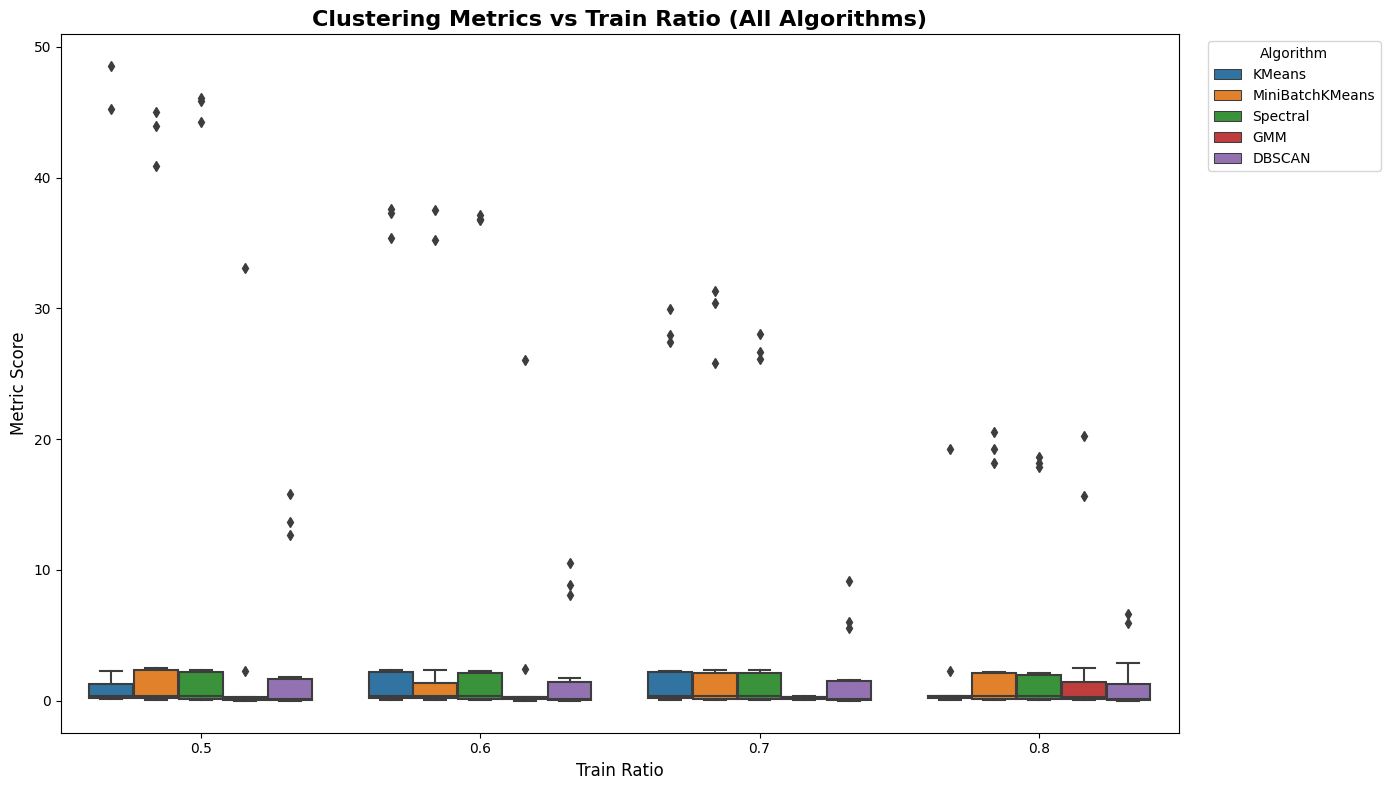

✅ Saved: /home/anirudh-sharma/Desktop/GITHUB Music Genere/Results/GTZAN/metrics_comparison.png


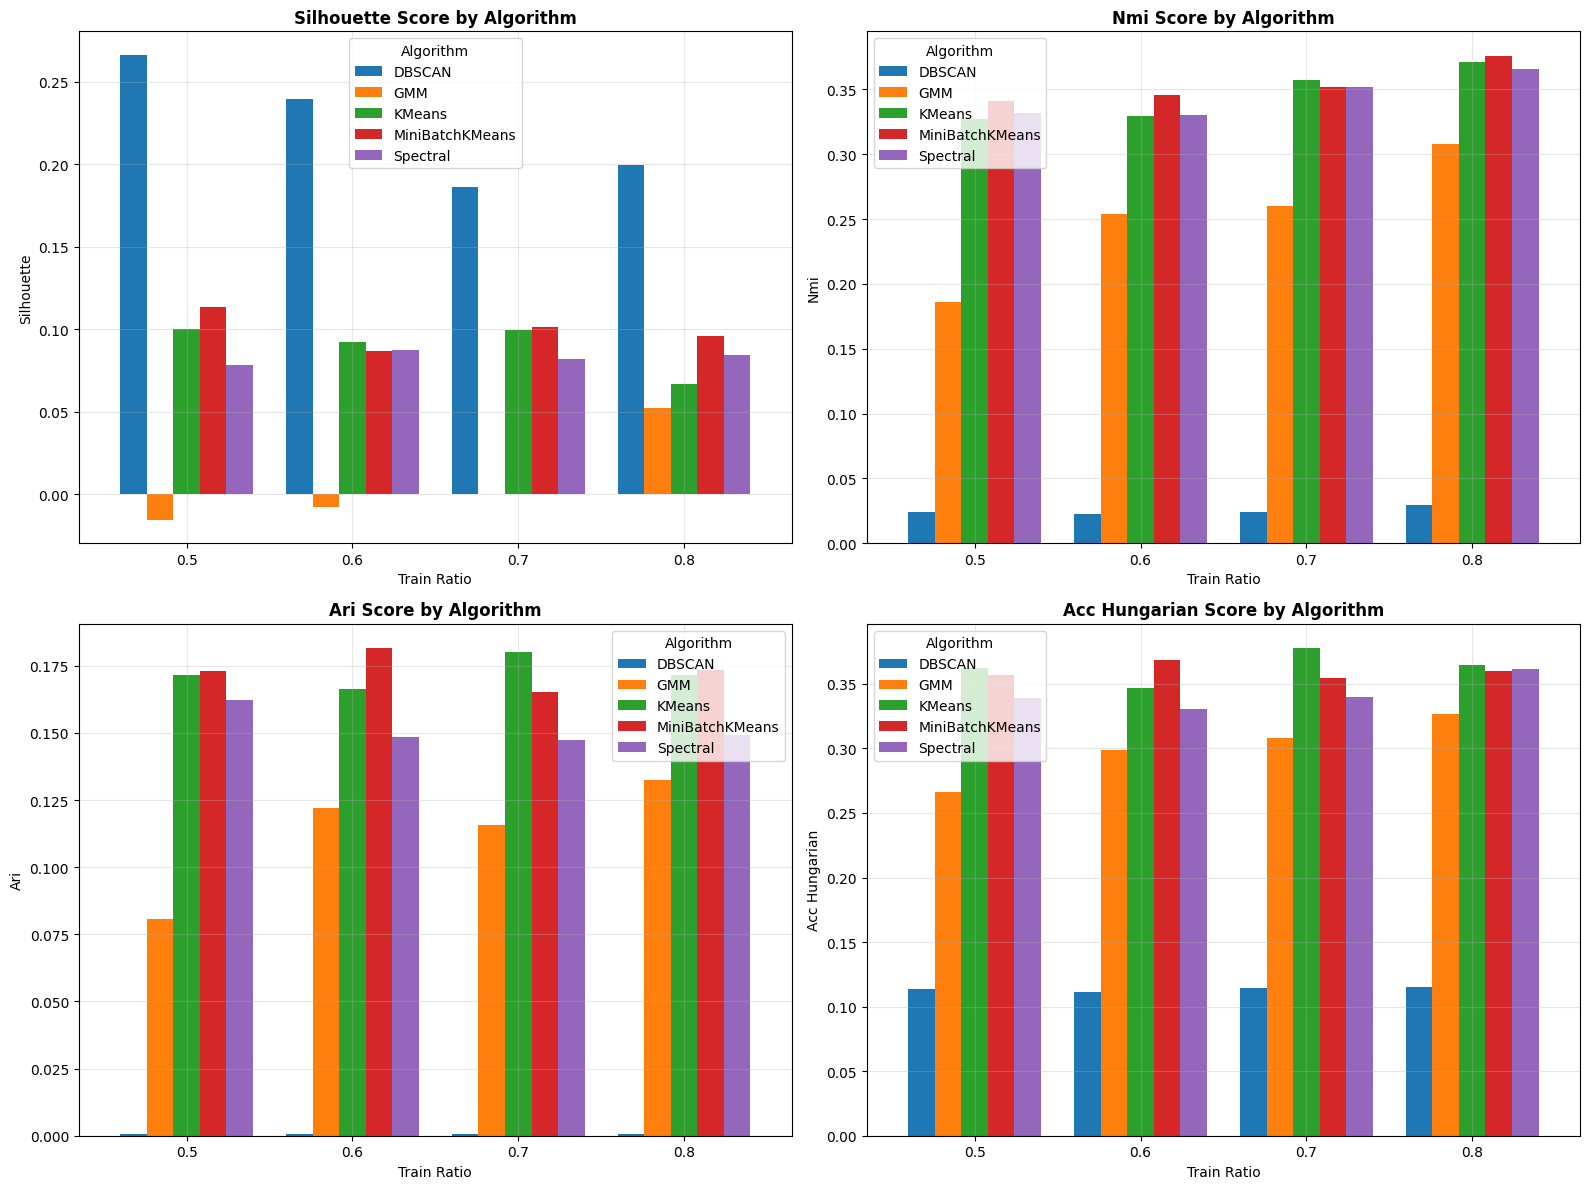

In [13]:
# VISUALIZATION 1: Boxplot comparison of all metrics
print("="*60)
print("COMPREHENSIVE VISUALIZATIONS")
print("="*60)

melted = res_df.melt(id_vars=["algo","train_ratio","random_state"],
                     value_vars=["silhouette","davies_bouldin","calinski_harabasz","nmi","ari","acc_hungarian"],
                     var_name="metric", value_name="score")

fig, ax = plt.subplots(figsize=(14, 8))
sns.boxplot(data=melted, x="train_ratio", y="score", hue="algo", ax=ax)
ax.set_title("Clustering Metrics vs Train Ratio (All Algorithms)", fontsize=16, fontweight='bold')
ax.set_xlabel("Train Ratio", fontsize=12)
ax.set_ylabel("Metric Score", fontsize=12)
ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left", title="Algorithm")
plt.tight_layout()
fig_path = os.path.join(OUTPUT_DIR, "boxplot_all_metrics.png")
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"✅ Saved: {fig_path}")
plt.show()

# VISUALIZATION 2: Individual metric comparisons
metrics_to_plot = ["silhouette", "nmi", "ari", "acc_hungarian"]
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx]
    metric_data = res_df.pivot_table(values=metric, index='train_ratio', columns='algo', aggfunc='mean')
    metric_data.plot(kind='bar', ax=ax, width=0.8)
    ax.set_title(f'{metric.replace("_", " ").title()} Score by Algorithm', fontsize=12, fontweight='bold')
    ax.set_xlabel('Train Ratio', fontsize=10)
    ax.set_ylabel(f'{metric.replace("_", " ").title()}', fontsize=10)
    ax.legend(title='Algorithm', loc='best')
    ax.grid(True, alpha=0.3)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

plt.tight_layout()
fig_path = os.path.join(OUTPUT_DIR, "metrics_comparison.png")
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"✅ Saved: {fig_path}")
plt.show()

# Log to W&B
tbl = wandb.Table(dataframe=res_df)
run = wandb.init(project=PROJECT, name="aggregate-results", reinit=True)
wandb.log({"results_table": tbl})
wandb.finish()

# 7 Advanced Visualizations: Heatmaps, Distributions, and Algorithm Performance


HEATMAP VISUALIZATIONS
✅ Saved: /home/anirudh-sharma/Desktop/GITHUB Music Genere/Results/GTZAN/heatmaps_all_metrics.png


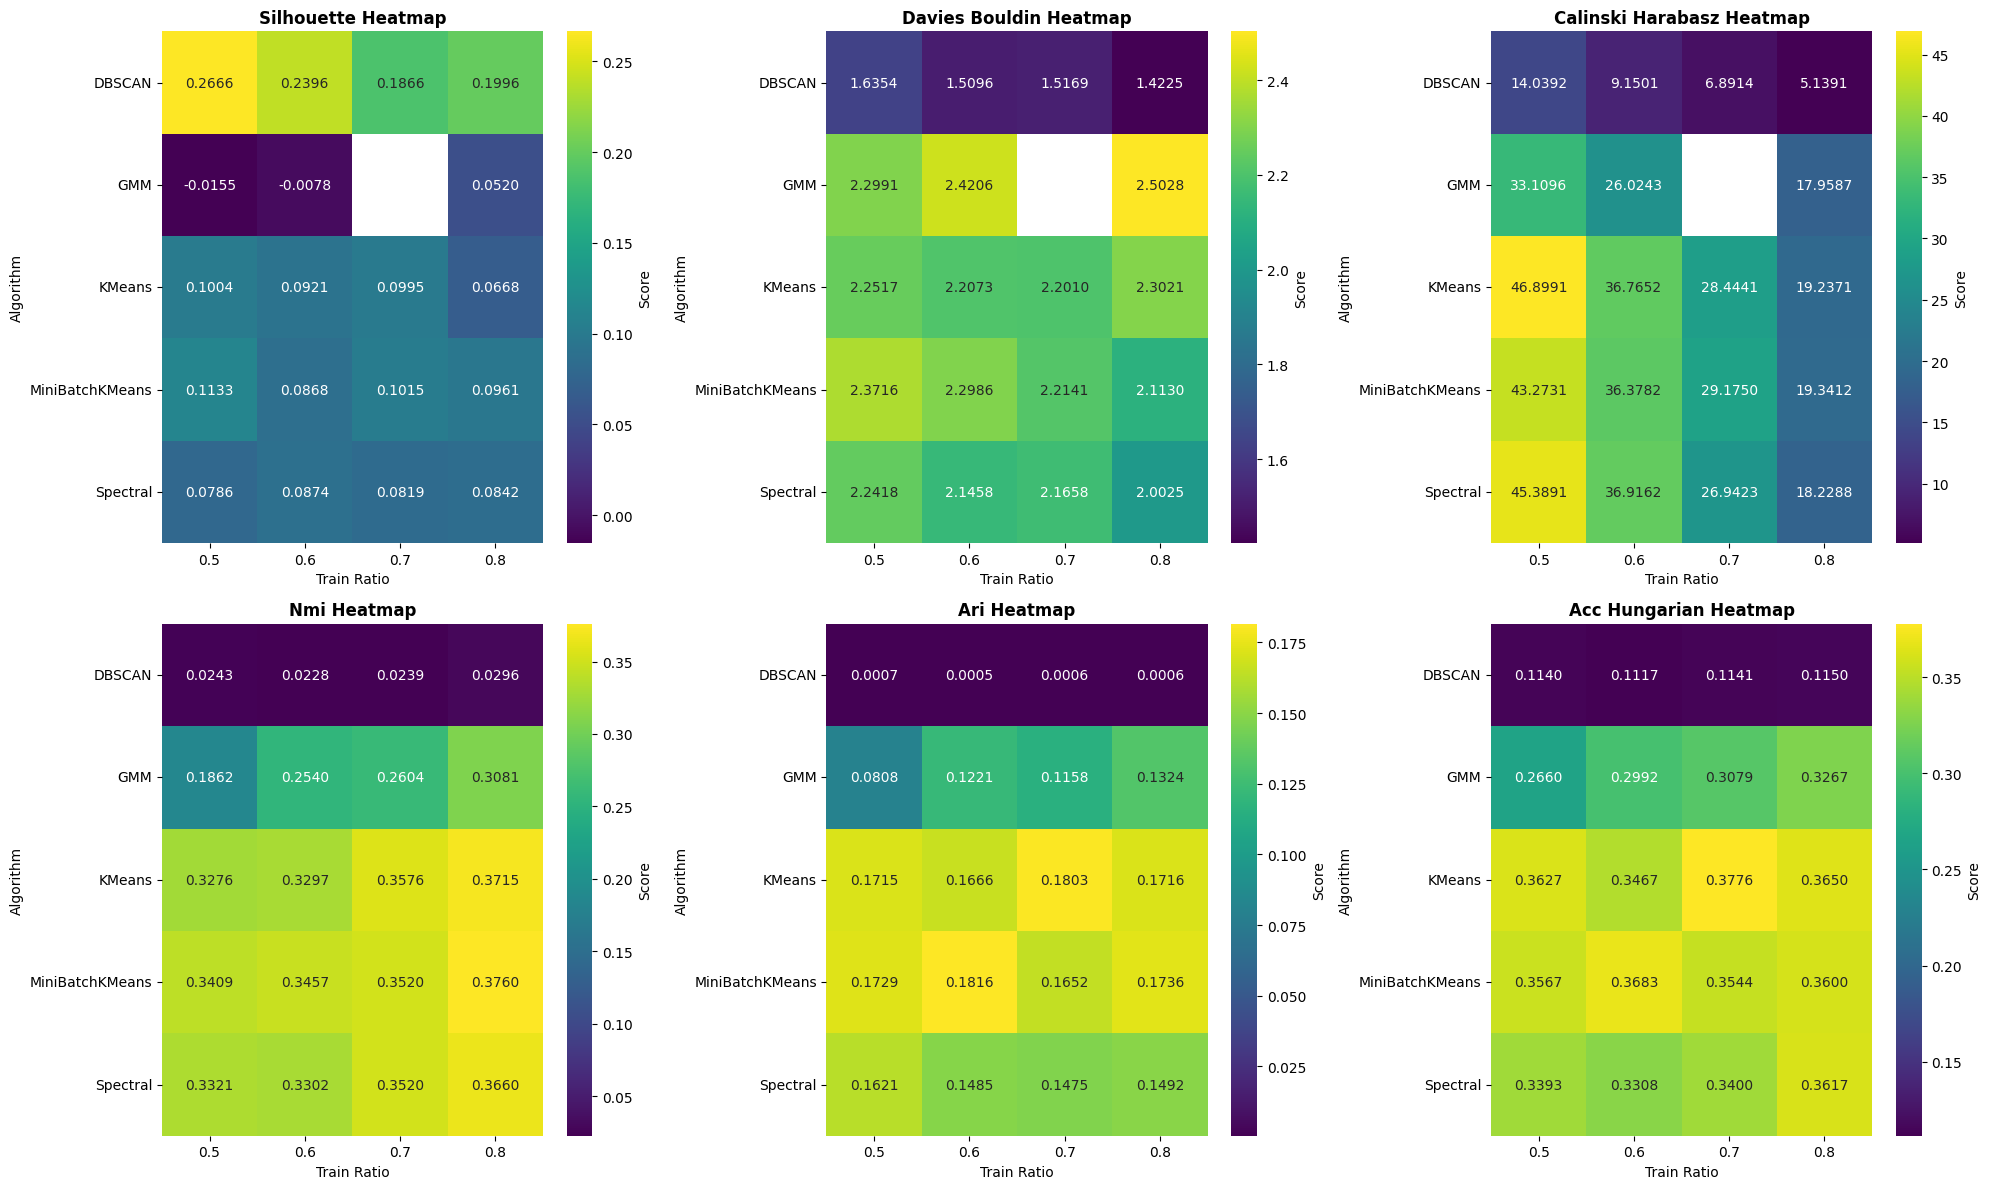

✅ Saved: /home/anirudh-sharma/Desktop/GITHUB Music Genere/Results/GTZAN/distribution_by_algorithm.png


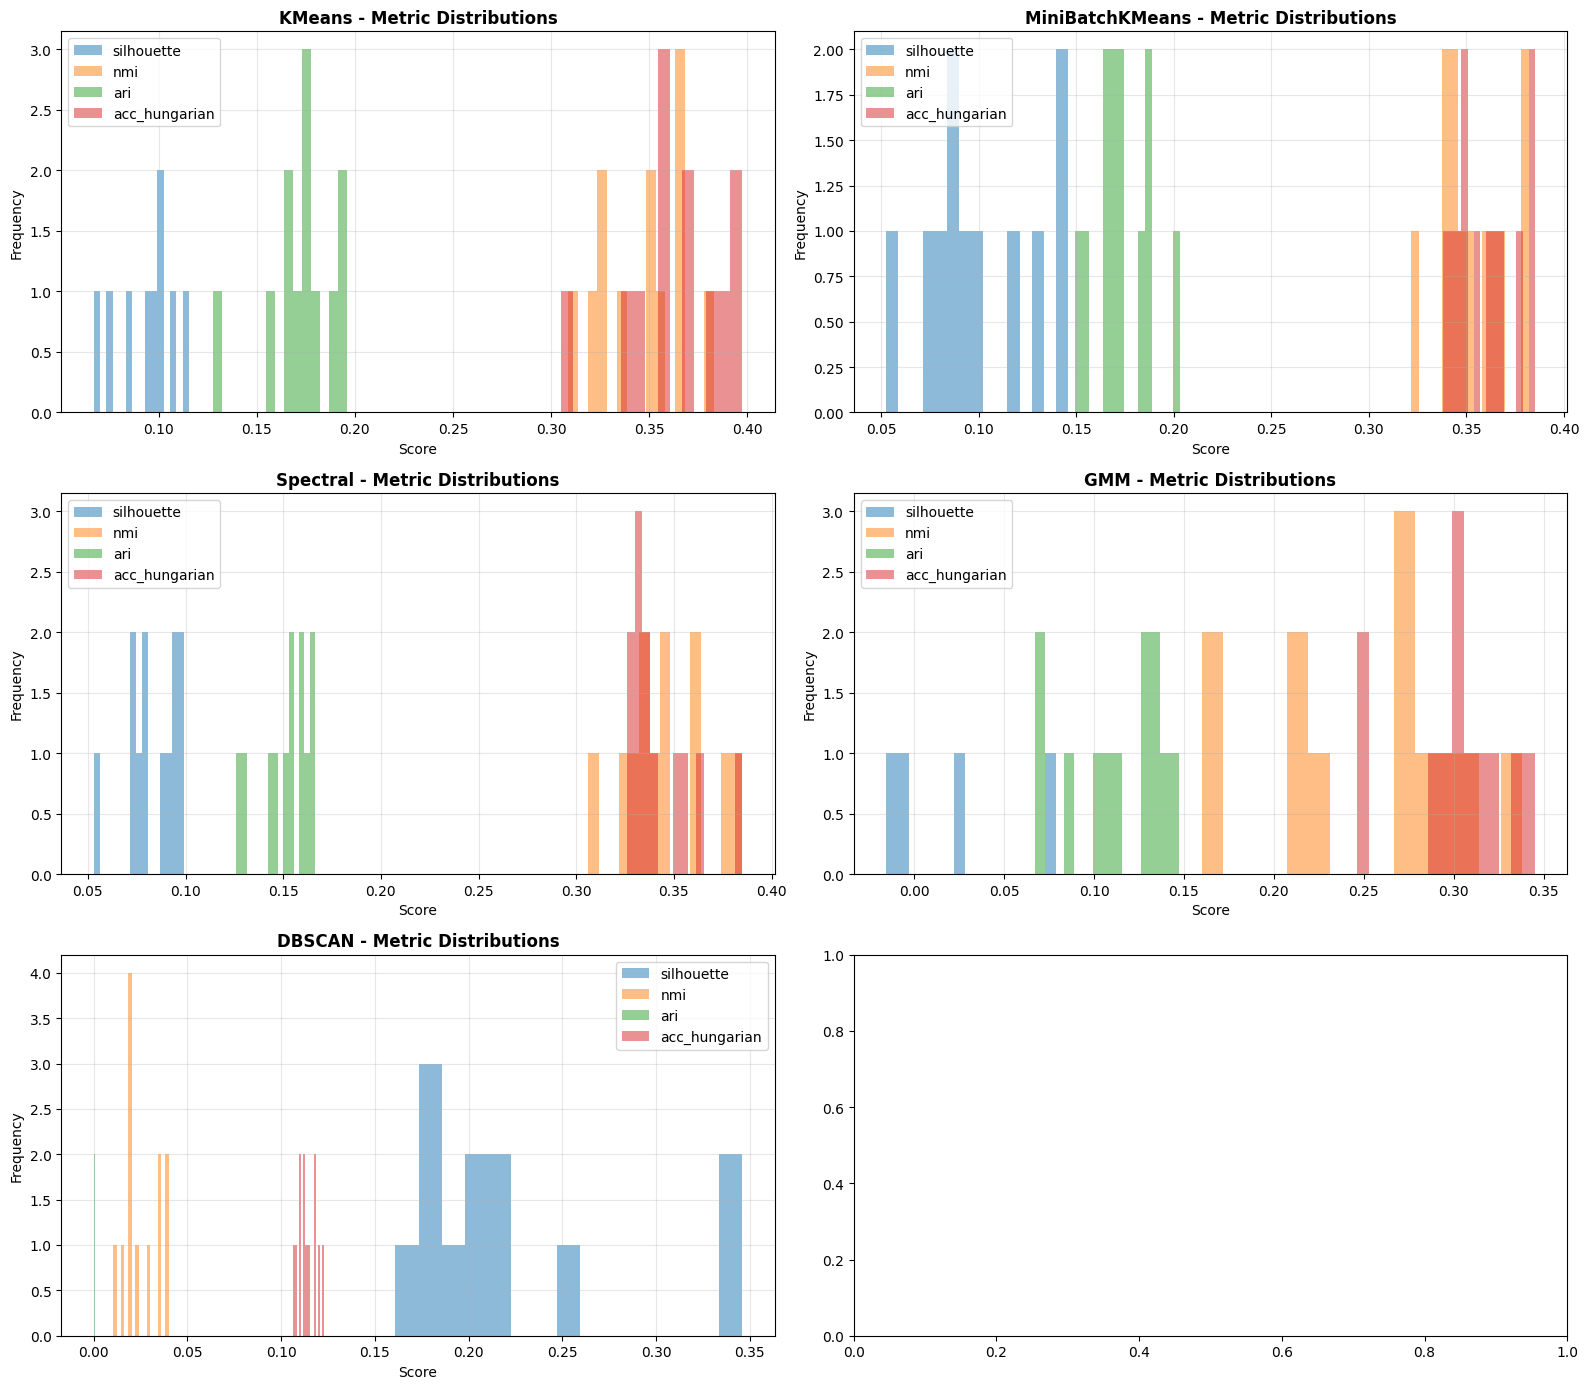

In [14]:
# VISUALIZATION 3: Heatmaps for each metric
print("\n" + "="*60)
print("HEATMAP VISUALIZATIONS")
print("="*60)

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for idx, metric in enumerate(numeric_cols):
    ax = axes[idx]
    pivot = res_df.pivot_table(values=metric, index='algo', columns='train_ratio', aggfunc='mean')
    sns.heatmap(pivot, annot=True, fmt='.4f', cmap='viridis', ax=ax, cbar_kws={'label': 'Score'})
    ax.set_title(f'{metric.replace("_", " ").title()} Heatmap', fontsize=12, fontweight='bold')
    ax.set_xlabel('Train Ratio', fontsize=10)
    ax.set_ylabel('Algorithm', fontsize=10)

plt.tight_layout()
fig_path = os.path.join(OUTPUT_DIR, "heatmaps_all_metrics.png")
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"✅ Saved: {fig_path}")
plt.show()

# VISUALIZATION 4: Distribution plots for each algorithm
fig, axes = plt.subplots(3, 2, figsize=(16, 14))
axes = axes.flatten()

algorithms = res_df['algo'].unique()
for idx, algo in enumerate(algorithms):
    if idx < len(axes):
        ax = axes[idx]
        algo_data = res_df[res_df['algo'] == algo]
        
        for metric in ['silhouette', 'nmi', 'ari', 'acc_hungarian']:
            ax.hist(algo_data[metric].dropna(), bins=15, alpha=0.5, label=metric)
        
        ax.set_title(f'{algo} - Metric Distributions', fontsize=12, fontweight='bold')
        ax.set_xlabel('Score', fontsize=10)
        ax.set_ylabel('Frequency', fontsize=10)
        ax.legend()
        ax.grid(True, alpha=0.3)

plt.tight_layout()
fig_path = os.path.join(OUTPUT_DIR, "distribution_by_algorithm.png")
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"✅ Saved: {fig_path}")
plt.show()


ALGORITHM RANKING ANALYSIS
✅ Saved: /home/anirudh-sharma/Desktop/GITHUB Music Genere/Results/GTZAN/algorithm_performance_ranking.png


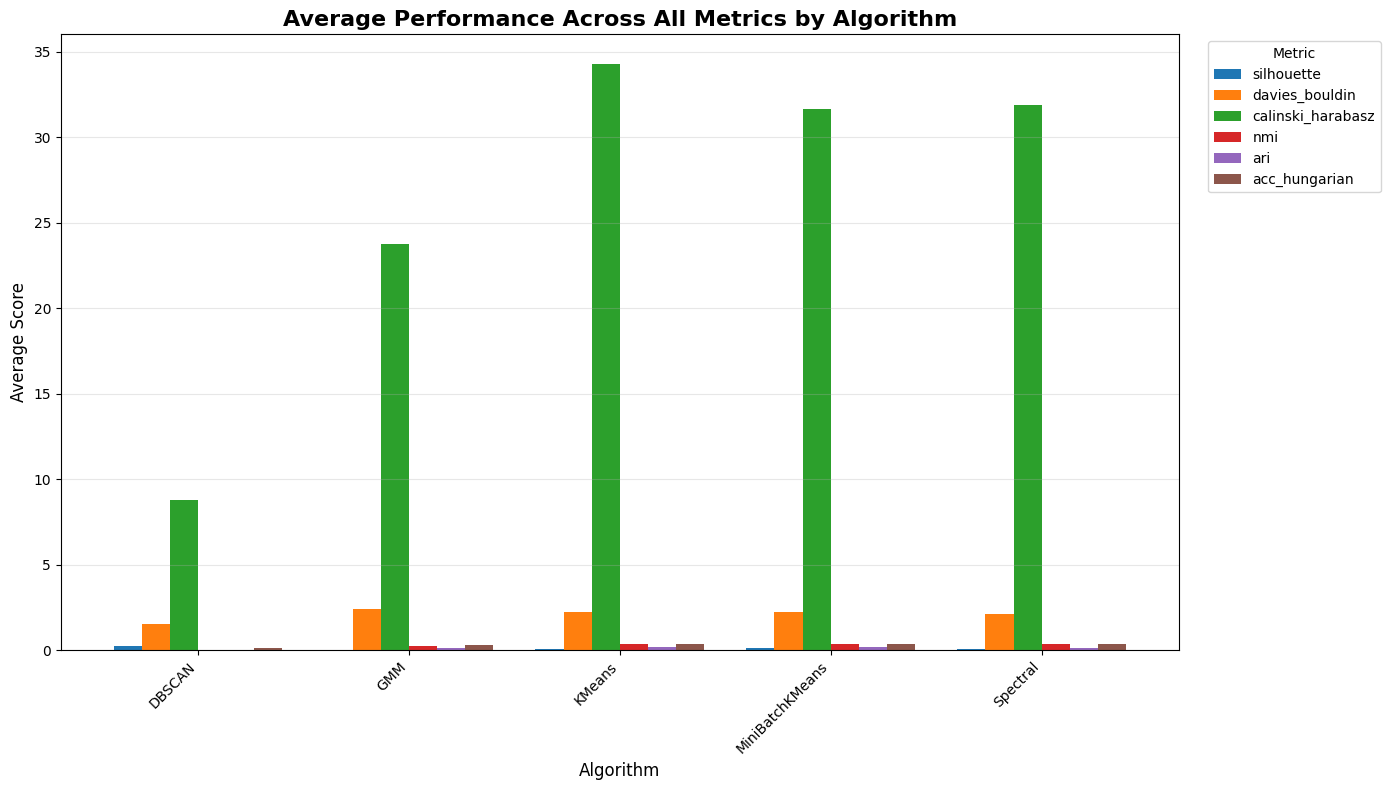


Algorithm Performance Summary:
------------------------------------------------------------


,silhouette,davies_bouldin,calinski_harabasz,nmi,ari,acc_hungarian
algo,,,,,,
DBSCAN,0.2231,1.5211,8.8049,0.0252,0.0006,0.1137
GMM,0.0202,2.4313,23.7628,0.2522,0.1128,0.2999
KMeans,0.0936,2.2256,34.2959,0.3466,0.1725,0.3630
MiniBatchKMeans,0.1006,2.2448,31.6477,0.3537,0.1733,0.3598
Spectral,0.0830,2.1389,31.8691,0.3451,0.1518,0.3430


✅ Saved: /home/anirudh-sharma/Desktop/GITHUB Music Genere/Results/GTZAN/algorithm_stability.png


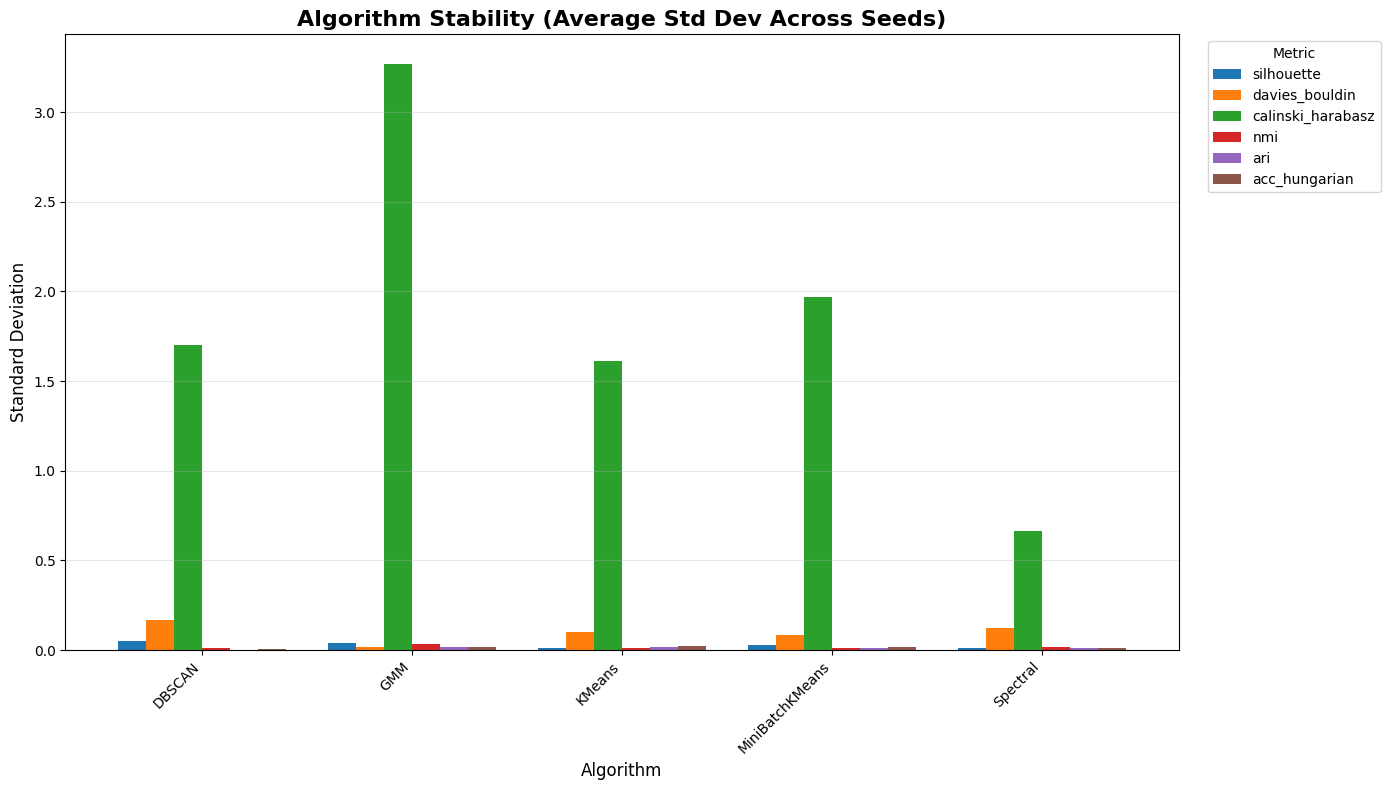


Stability Analysis (Lower is Better):
------------------------------------------------------------


,silhouette,davies_bouldin,calinski_harabasz,nmi,ari,acc_hungarian
algo,,,,,,
DBSCAN,0.0526,0.1689,1.7002,0.0108,0.0006,0.0055
GMM,0.0378,0.0154,3.2697,0.0361,0.0196,0.0190
KMeans,0.0112,0.0990,1.6100,0.0114,0.0174,0.0236
MiniBatchKMeans,0.0262,0.0854,1.9689,0.0104,0.0136,0.0166
Spectral,0.0125,0.1254,0.6623,0.0183,0.0120,0.0132


In [15]:
# VISUALIZATION 5: Algorithm performance ranking
print("\n" + "="*60)
print("ALGORITHM RANKING ANALYSIS")
print("="*60)

# Calculate average rank for each algorithm across all metrics
rank_df = res_df.groupby('algo')[numeric_cols].mean()

fig, ax = plt.subplots(figsize=(14, 8))
rank_df.plot(kind='bar', ax=ax, width=0.8)
ax.set_title('Average Performance Across All Metrics by Algorithm', fontsize=16, fontweight='bold')
ax.set_xlabel('Algorithm', fontsize=12)
ax.set_ylabel('Average Score', fontsize=12)
ax.legend(title='Metric', bbox_to_anchor=(1.02, 1), loc='upper left')
ax.grid(True, alpha=0.3, axis='y')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
fig_path = os.path.join(OUTPUT_DIR, "algorithm_performance_ranking.png")
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"✅ Saved: {fig_path}")
plt.show()

# Display ranking table
print("\nAlgorithm Performance Summary:")
print("-"*60)
display(rank_df.round(4))

# VISUALIZATION 6: Stability analysis (std dev across seeds)
stability = res_df.groupby(['algo', 'train_ratio'])[numeric_cols].std().reset_index()
stability_avg = stability.groupby('algo')[numeric_cols].mean()

fig, ax = plt.subplots(figsize=(14, 8))
stability_avg.plot(kind='bar', ax=ax, width=0.8)
ax.set_title('Algorithm Stability (Average Std Dev Across Seeds)', fontsize=16, fontweight='bold')
ax.set_xlabel('Algorithm', fontsize=12)
ax.set_ylabel('Standard Deviation', fontsize=12)
ax.legend(title='Metric', bbox_to_anchor=(1.02, 1), loc='upper left')
ax.grid(True, alpha=0.3, axis='y')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
fig_path = os.path.join(OUTPUT_DIR, "algorithm_stability.png")
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"✅ Saved: {fig_path}")
plt.show()

print("\nStability Analysis (Lower is Better):")
print("-"*60)
display(stability_avg.round(4))


DBSCAN-SPECIFIC ANALYSIS
✅ Saved: /home/anirudh-sharma/Desktop/GITHUB Music Genere/Results/GTZAN/dbscan_analysis.png


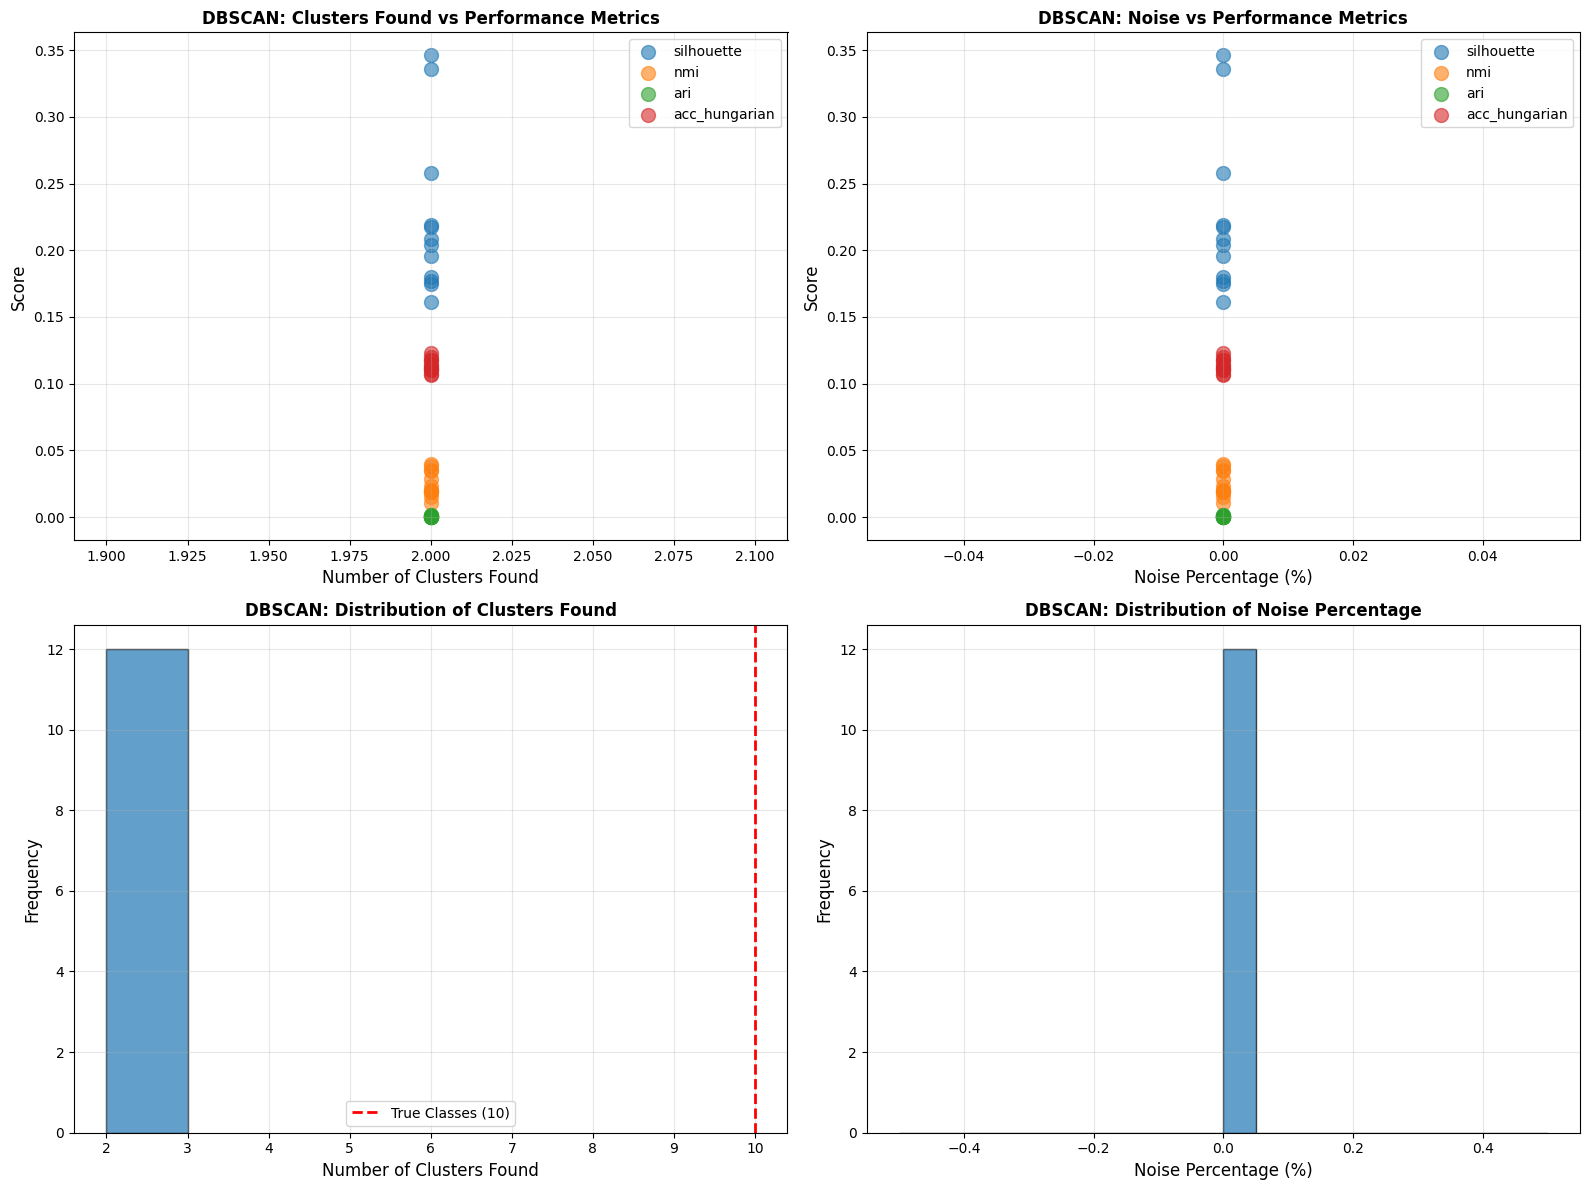


DBSCAN Statistics:
------------------------------------------------------------
Average clusters found: 2.00 ± 0.00
Min clusters: 2
Max clusters: 2
Average noise: 0.00% ± 0.00%
Min noise: 0.00%
Max noise: 0.00%

✅ DBSCAN detailed results saved to: /home/anirudh-sharma/Desktop/GITHUB Music Genere/Results/GTZAN/dbscan_detailed_results.csv


In [16]:
# VISUALIZATION 7: DBSCAN-specific analysis
print("\n" + "="*60)
print("DBSCAN-SPECIFIC ANALYSIS")
print("="*60)

dbscan_data = res_df[res_df['algo'] == 'DBSCAN'].copy()

if len(dbscan_data) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: Clusters found vs metrics
    ax = axes[0, 0]
    scatter_metrics = ['silhouette', 'nmi', 'ari', 'acc_hungarian']
    for metric in scatter_metrics:
        ax.scatter(dbscan_data['n_clusters_found'], dbscan_data[metric], 
                  alpha=0.6, s=100, label=metric)
    ax.set_xlabel('Number of Clusters Found', fontsize=12)
    ax.set_ylabel('Score', fontsize=12)
    ax.set_title('DBSCAN: Clusters Found vs Performance Metrics', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 2: Noise percentage vs metrics
    ax = axes[0, 1]
    if 'noise_pct' in dbscan_data.columns:
        for metric in scatter_metrics:
            ax.scatter(dbscan_data['noise_pct'], dbscan_data[metric], 
                      alpha=0.6, s=100, label=metric)
        ax.set_xlabel('Noise Percentage (%)', fontsize=12)
        ax.set_ylabel('Score', fontsize=12)
        ax.set_title('DBSCAN: Noise vs Performance Metrics', fontsize=12, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    # Plot 3: Distribution of clusters found
    ax = axes[1, 0]
    ax.hist(dbscan_data['n_clusters_found'], bins=range(int(dbscan_data['n_clusters_found'].min()), 
                                                          int(dbscan_data['n_clusters_found'].max())+2), 
           edgecolor='black', alpha=0.7)
    ax.set_xlabel('Number of Clusters Found', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.set_title('DBSCAN: Distribution of Clusters Found', fontsize=12, fontweight='bold')
    ax.axvline(n_classes, color='red', linestyle='--', linewidth=2, label=f'True Classes ({n_classes})')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 4: Noise distribution
    ax = axes[1, 1]
    if 'noise_pct' in dbscan_data.columns:
        ax.hist(dbscan_data['noise_pct'], bins=20, edgecolor='black', alpha=0.7)
        ax.set_xlabel('Noise Percentage (%)', fontsize=12)
        ax.set_ylabel('Frequency', fontsize=12)
        ax.set_title('DBSCAN: Distribution of Noise Percentage', fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    fig_path = os.path.join(OUTPUT_DIR, "dbscan_analysis.png")
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    print(f"✅ Saved: {fig_path}")
    plt.show()
    
    # DBSCAN statistics
    print("\nDBSCAN Statistics:")
    print("-"*60)
    print(f"Average clusters found: {dbscan_data['n_clusters_found'].mean():.2f} ± {dbscan_data['n_clusters_found'].std():.2f}")
    print(f"Min clusters: {dbscan_data['n_clusters_found'].min()}")
    print(f"Max clusters: {dbscan_data['n_clusters_found'].max()}")
    if 'noise_pct' in dbscan_data.columns:
        print(f"Average noise: {dbscan_data['noise_pct'].mean():.2f}% ± {dbscan_data['noise_pct'].std():.2f}%")
        print(f"Min noise: {dbscan_data['noise_pct'].min():.2f}%")
        print(f"Max noise: {dbscan_data['noise_pct'].max():.2f}%")
    
    # Save DBSCAN-specific results
    dbscan_file = os.path.join(OUTPUT_DIR, "dbscan_detailed_results.csv")
    dbscan_data.to_csv(dbscan_file, index=False)
    print(f"\n✅ DBSCAN detailed results saved to: {dbscan_file}")
else:
    print("⚠️ No DBSCAN results found in the dataset.")


RADAR CHART COMPARISON
✅ Saved: /home/anirudh-sharma/Desktop/GITHUB Music Genere/Results/GTZAN/radar_chart_comparison.png


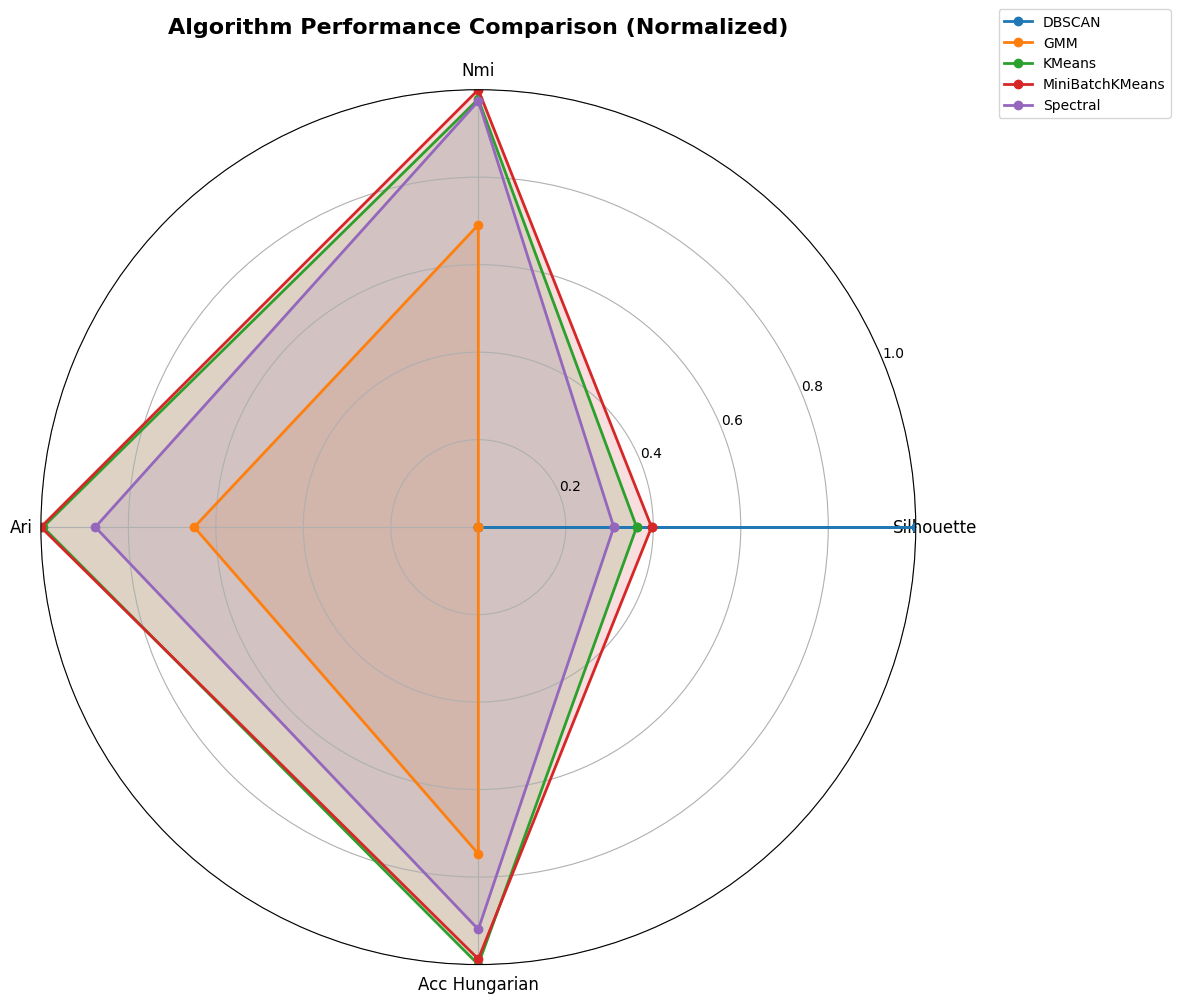

In [17]:
# VISUALIZATION 8: Radar charts for algorithm comparison
print("\n" + "="*60)
print("RADAR CHART COMPARISON")
print("="*60)

from math import pi

# Normalize metrics to 0-1 scale for radar chart
radar_metrics = ['silhouette', 'nmi', 'ari', 'acc_hungarian']
radar_data = res_df.groupby('algo')[radar_metrics].mean()

# Normalize each metric to 0-1
for col in radar_metrics:
    min_val = radar_data[col].min()
    max_val = radar_data[col].max()
    if max_val > min_val:
        radar_data[col] = (radar_data[col] - min_val) / (max_val - min_val)

# Create radar chart
angles = [n / float(len(radar_metrics)) * 2 * pi for n in range(len(radar_metrics))]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(12, 12), subplot_kw=dict(projection='polar'))

for algo in radar_data.index:
    values = radar_data.loc[algo].values.tolist()
    values += values[:1]
    ax.plot(angles, values, 'o-', linewidth=2, label=algo)
    ax.fill(angles, values, alpha=0.15)

ax.set_xticks(angles[:-1])
ax.set_xticklabels([m.replace('_', ' ').title() for m in radar_metrics], size=12)
ax.set_ylim(0, 1)
ax.set_title('Algorithm Performance Comparison (Normalized)', size=16, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
ax.grid(True)

plt.tight_layout()
fig_path = os.path.join(OUTPUT_DIR, "radar_chart_comparison.png")
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"✅ Saved: {fig_path}")
plt.show()

# 8 Final Summary and Recommendations

In [18]:
# Generate final comprehensive report
print("="*80)
print(" "*20 + "FINAL EXPERIMENT REPORT")
print("="*80)

# 1. Dataset Information
print("\n1. DATASET INFORMATION")
print("-"*80)
print(f"   Dataset: {os.path.basename(DATA_PATH)}")
print(f"   Total samples: {len(X_scaled)}")
print(f"   Number of features: {X_scaled.shape[1]}")
print(f"   Number of classes: {n_classes}")
print(f"   Classes: {', '.join(le.classes_)}")

# 2. Experiment Configuration
print("\n2. EXPERIMENT CONFIGURATION")
print("-"*80)
print(f"   Train/Test splits tested: {SPLITS}")
print(f"   Random seeds used: {SEEDS}")
print(f"   Total experiments: {len(ALL_RUNS)}")
print(f"   Algorithms tested: {', '.join(res_df['algo'].unique())}")

# 3. DBSCAN Configuration
print("\n3. DBSCAN PARAMETERS (AUTO-TUNED)")
print("-"*80)
print(f"   eps: {DBSCAN_EPS:.4f}")
print(f"   min_samples: {DBSCAN_MIN_SAMPLES}")

# 4. Best Overall Algorithm
print("\n4. BEST OVERALL ALGORITHM (by Average Silhouette Score)")
print("-"*80)
best_algo = res_df.groupby('algo')['silhouette'].mean().idxmax()
best_metrics = res_df[res_df['algo'] == best_algo][numeric_cols].mean()
print(f"   🏆 Winner: {best_algo}")
print(f"   Metrics:")
for metric, value in best_metrics.items():
    print(f"      {metric}: {value:.4f}")

# 5. Best Configuration Overall
print("\n5. BEST SINGLE CONFIGURATION (Highest Silhouette)")
print("-"*80)
best_run = res_df.loc[res_df['silhouette'].idxmax()]
print(f"   Algorithm: {best_run['algo']}")
print(f"   Train Ratio: {best_run['train_ratio']}")
print(f"   Random Seed: {best_run['random_state']}")
print(f"   Metrics:")
for metric in numeric_cols:
    print(f"      {metric}: {best_run[metric]:.4f}")

# 6. Algorithm Rankings
print("\n6. ALGORITHM RANKINGS (by Average Metrics)")
print("-"*80)
avg_scores = res_df.groupby('algo')[numeric_cols].mean()
# Compute composite score (higher is better for all except davies_bouldin)
composite = avg_scores.copy()
composite['davies_bouldin'] = 1 / (1 + composite['davies_bouldin'])  # Invert (lower is better)
composite['composite_score'] = composite.mean(axis=1)
rankings = composite.sort_values('composite_score', ascending=False)

for rank, (algo, row) in enumerate(rankings.iterrows(), 1):
    print(f"   {rank}. {algo} (Composite Score: {row['composite_score']:.4f})")

# 7. Save comprehensive report
report_lines = []
report_lines.append("="*80)
report_lines.append(" "*20 + "GTZAN CLUSTERING EXPERIMENT REPORT")
report_lines.append("="*80)
report_lines.append(f"\nGenerated: {pd.Timestamp.now()}")
report_lines.append(f"\nDataset: {os.path.basename(DATA_PATH)}")
report_lines.append(f"Total Samples: {len(X_scaled)}")
report_lines.append(f"Features: {X_scaled.shape[1]}")
report_lines.append(f"Classes: {n_classes} ({', '.join(le.classes_)})")
report_lines.append(f"\nTotal Experiments: {len(ALL_RUNS)}")
report_lines.append(f"Algorithms: {', '.join(res_df['algo'].unique())}")
report_lines.append(f"\nBest Algorithm: {best_algo}")
report_lines.append(f"Best Configuration: {best_run['algo']} (train_ratio={best_run['train_ratio']}, seed={best_run['random_state']})")
report_lines.append("\n" + "="*80)
report_lines.append("\nALGORITHM RANKINGS:")
report_lines.append("-"*80)
for rank, (algo, row) in enumerate(rankings.iterrows(), 1):
    report_lines.append(f"{rank}. {algo} (Score: {row['composite_score']:.4f})")
report_lines.append("\n" + "="*80)
report_lines.append("\nFILES GENERATED:")
report_lines.append("-"*80)
report_lines.append(f"1. clustering_results_detailed.csv - All experiment results")
report_lines.append(f"2. clustering_results_summary.csv - Aggregated statistics")
report_lines.append(f"3. best_configurations.csv - Best config per algorithm")
report_lines.append(f"4. dbscan_detailed_results.csv - DBSCAN-specific analysis")
report_lines.append(f"5. Multiple visualization PNG files")
report_lines.append("="*80)

report_text = "\n".join(report_lines)
report_file = os.path.join(OUTPUT_DIR, "experiment_report.txt")
with open(report_file, 'w') as f:
    f.write(report_text)

print(f"\n✅ Comprehensive report saved to: {report_file}")
print("\n" + "="*80)
print("ALL RESULTS SAVED TO:", OUTPUT_DIR)
print("="*80)

                    FINAL EXPERIMENT REPORT

1. DATASET INFORMATION
--------------------------------------------------------------------------------
   Dataset: features_30_sec.csv
   Total samples: 1000
   Number of features: 57
   Number of classes: 10
   Classes: blues, classical, country, disco, hiphop, jazz, metal, pop, reggae, rock

2. EXPERIMENT CONFIGURATION
--------------------------------------------------------------------------------
   Train/Test splits tested: [0.5, 0.6, 0.7, 0.8]
   Random seeds used: [0, 42, 1337]
   Total experiments: 60
   Algorithms tested: KMeans, MiniBatchKMeans, Spectral, GMM, DBSCAN

3. DBSCAN PARAMETERS (AUTO-TUNED)
--------------------------------------------------------------------------------
   eps: 6.2636
   min_samples: 3

4. BEST OVERALL ALGORITHM (by Average Silhouette Score)
--------------------------------------------------------------------------------
   🏆 Winner: DBSCAN
   Metrics:
      silhouette: 0.2231
      davies_bouldin: 1.52

# 📋 Quick Reference - Output Files Guide

## CSV Files Generated:

### 1. **clustering_results_detailed.csv**
Contains all individual experiment runs with columns:
- Algorithm parameters (algo, train_ratio, random_state, etc.)
- All 6 metrics (silhouette, davies_bouldin, calinski_harabasz, nmi, ari, acc_hungarian)
- Sample counts (train_samples, test_samples)
- DBSCAN-specific (n_clusters_found, noise_points, noise_pct)

### 2. **clustering_results_summary.csv**
Aggregated statistics (mean ± std) grouped by:
- Algorithm
- Train ratio

### 3. **best_configurations.csv**
Best performing configuration for each algorithm (by silhouette score)

### 4. **dbscan_detailed_results.csv**
DBSCAN-only experiments with additional analysis

### 5. **experiment_report.txt**
Human-readable summary report

## Visualization Files:

1. `boxplot_all_metrics.png` - Overall comparison
2. `metrics_comparison.png` - 4 key metrics side-by-side
3. `heatmaps_all_metrics.png` - 6 heatmaps showing algorithm×train_ratio
4. `distribution_by_algorithm.png` - Metric distributions per algorithm
5. `algorithm_performance_ranking.png` - Average scores comparison
6. `algorithm_stability.png` - Stability analysis (std dev)
7. `dbscan_analysis.png` - 4 DBSCAN-specific plots
8. `radar_chart_comparison.png` - Normalized algorithm comparison

---

## 🔍 How to Interpret Results:

### For Later Analysis:
1. Load CSV: `df = pd.read_csv('Results/GTZAN/clustering_results_detailed.csv')`
2. Filter by algorithm: `df[df['algo'] == 'DBSCAN']`
3. Find best: `df.loc[df['silhouette'].idxmax()]`
4. Compare algorithms: `df.groupby('algo')['silhouette'].mean()`

### Key Metrics to Focus On:
- **Silhouette** (0 to 1, higher is better) - Overall cluster quality
- **NMI** (0 to 1, higher is better) - Agreement with true labels
- **ARI** (-1 to 1, higher is better) - Adjusted agreement
- **Accuracy (Hungarian)** (0 to 1, higher is better) - Classification accuracy after optimal mapping

### DBSCAN Success Indicators:
- ✅ `n_clusters_found` between 5-15
- ✅ `noise_pct` between 5-20%
- ✅ `silhouette` > 0.3
- ✅ Multiple clusters (not just 1!)

In [19]:
# List all generated files
print("="*80)
print("📁 ALL GENERATED FILES")
print("="*80)
print(f"\nOutput Directory: {OUTPUT_DIR}\n")

import glob
all_files = glob.glob(os.path.join(OUTPUT_DIR, "*"))
all_files.sort()

csv_files = [f for f in all_files if f.endswith('.csv')]
png_files = [f for f in all_files if f.endswith('.png')]
txt_files = [f for f in all_files if f.endswith('.txt')]

print("📊 CSV FILES:")
print("-"*80)
for f in csv_files:
    size = os.path.getsize(f) / 1024  # KB
    print(f"   {os.path.basename(f):50s} ({size:8.2f} KB)")

print("\n🖼️  VISUALIZATION FILES:")
print("-"*80)
for f in png_files:
    size = os.path.getsize(f) / 1024  # KB
    print(f"   {os.path.basename(f):50s} ({size:8.2f} KB)")

print("\n📝 REPORT FILES:")
print("-"*80)
for f in txt_files:
    size = os.path.getsize(f) / 1024  # KB
    print(f"   {os.path.basename(f):50s} ({size:8.2f} KB)")

print("\n" + "="*80)
print(f"✅ TOTAL FILES GENERATED: {len(all_files)}")
print(f"   CSV: {len(csv_files)}, PNG: {len(png_files)}, TXT: {len(txt_files)}")
print("="*80)

# Display a sample of the detailed results
print("\n📋 PREVIEW: First 5 rows of detailed results")
print("-"*80)
if os.path.exists(results_file):
    preview = pd.read_csv(results_file).head()
    display(preview[['algo', 'train_ratio', 'random_state', 'silhouette', 'nmi', 'ari', 'acc_hungarian', 'n_clusters_found']])

📁 ALL GENERATED FILES

Output Directory: /home/anirudh-sharma/Desktop/GITHUB Music Genere/Results/GTZAN

📊 CSV FILES:
--------------------------------------------------------------------------------
   best_configurations.csv                            (    1.12 KB)
   clustering_results_detailed.csv                    (   10.12 KB)
   clustering_results_summary.csv                     (    4.82 KB)
   dbscan_detailed_results.csv                        (    2.58 KB)

🖼️  VISUALIZATION FILES:
--------------------------------------------------------------------------------
   algorithm_performance_ranking.png                  (  192.19 KB)
   algorithm_stability.png                            (  195.82 KB)
   boxplot_all_metrics.png                            (  167.52 KB)
   dbscan_analysis.png                                (  351.72 KB)
   distribution_by_algorithm.png                      (  361.24 KB)
   heatmaps_all_metrics.png                           (  755.62 KB)
   metrics_com

,algo,train_ratio,random_state,silhouette,nmi,ari,acc_hungarian,n_clusters_found
0,KMeans,0.5,0,NaN,0.326183,0.176756,0.346,10
1,MiniBatchKMeans,0.5,0,0.145843,0.339340,0.166162,0.348,10
2,Spectral,0.5,0,0.079274,0.344100,0.165571,0.338,10
3,GMM,0.5,0,-0.015542,0.228128,0.104352,0.304,6
4,DBSCAN,0.5,0,0.195857,0.034238,0.001164,0.118,2
